In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import sys
import os

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")

In [78]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)
invalid_subjs = qa_records['invalid']

In [79]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 2), 'gaze_analysis', 'features')
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

In [80]:
def load_subj_behav_data(subj):
    behav_data = pd.read_csv(os.path.join(
        DEFAULT_FEATURE_FOLDER, str(subj), 'behavior.csv'), index_col=0)
    return behav_data

In [81]:
RESULTS_PATH = os.path.join(get_n_dir_up(CUR_PATH, 3), 'results')
PLOTS_FOLDER = os.path.join(RESULTS_PATH, 'images', 'behavior', 'behavior_gaze')

## Compare Draw v.s. Click

### convert response to distribution

In [82]:
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

from utils.inverted_encoding import (
    compute_accuracy, compute_bias, deg_signed_diff,
)

In [83]:
from utils.eye_plotting import set_general_plt_styles

set_general_plt_styles()

In [84]:
from utils.behav_analysis_helper import df_to_errs, errdf_to_distrib

In [85]:
example_df = load_subj_behav_data(908)
example_err_df = df_to_errs(example_df, None)

In [86]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

#### plot the err distribution

In [87]:
from utils.inverted_encoding import (
    raw_display_shifted_distrib, 
    deg_signed_diff,
    compute_accuracy
)


def compute_smoothing_weight(sharpness=150):
    # compute weights
    resp = np.arange(180)
    outer_diffs = deg_signed_diff(
        np.subtract.outer(resp, resp))
    outer_sims = np.cos(np.deg2rad(outer_diffs))
    weights = np.exp(outer_sims * sharpness)
    weights = weights / np.sum(weights, axis=1, keepdims=True)
    return weights

SMOOTHING_WEIGHTS = compute_smoothing_weight()

def plot_behav_err_distrib(
        ax, lmb=None, ref_type=None,
        ylim_max=0.0305,
        **kwargs):
    
    ref = {
        'target': None,
        'previous': 'prev_resp',
        'nontarget': 'non_target',
    }[ref_type]

    # collect subject data
    subj_names = []
    subj_data = []
    for subj in all_subjs:
        behav_data = load_subj_behav_data(subj)
        err_df = df_to_errs(behav_data, lmb)
        distrib = errdf_to_distrib(err_df, ref=ref)

        if len(distrib) == 0:
            continue

        # apply smoothing
        distrib = np.dot(
            SMOOTHING_WEIGHTS, distrib)

        subj_names.append(int(subj))
        subj_data.append(distrib)

    # plot the result
    distrib = np.array(subj_data)
    subj_series = pd.Series(subj_names)
    raw_display_shifted_distrib(
        ax, distrib, ref_type=ref_type,
        mask=None, subj_series=subj_series,
        ylim_min=-0.0005, ylim_max=ylim_max,
        **kwargs)
    
    # also compute the stats
    accs = {}
    for subj, distrib in zip(subj_names, subj_data):
        acc = compute_accuracy(distrib)
        accs[subj] = acc
    return accs

In [88]:
MODE_COLORS = {
    'draw': 'skyblue',
    'click': 'coral',
}

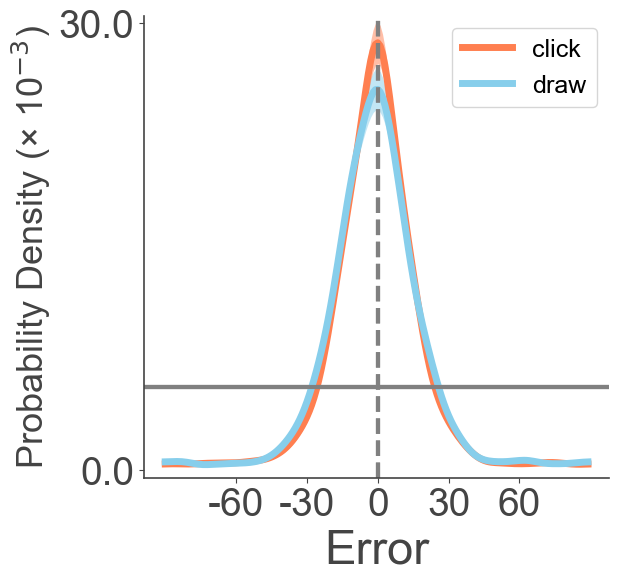

In [89]:
fig, ax = plt.subplots(1, figsize=(6, 6))

CLICK_ACCS = plot_behav_err_distrib(
    ax, lmb=click_lmb, ref_type='target',
    label='click', plot_line_color=MODE_COLORS['click'])
DRAW_ACCS = plot_behav_err_distrib(
    ax, lmb=draw_lmb, ref_type='target',
    label='draw', plot_line_color=MODE_COLORS['draw'])

ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=18)

In [90]:
from utils.stats_test import display_ttest_rel2_results

formatted_accs = {
    'click': {'accuracy': CLICK_ACCS},
    'draw': {'accuracy': DRAW_ACCS},
}
display_ttest_rel2_results(formatted_accs, ['click', 'draw'])

Group: accuracy
: normality_p = 0.854
:: ttest: t(35)=-0.89 (p=0.378)
:: wilcoxon: W=278, n=36 (p=0.396)


#### separate load=1 and load=2

In [91]:
mem_load1_mask = lambda df: ((df['trial_code'] == 0) & (~(df['stim_1_to_report'] & df['stim_2_to_report']))).to_numpy()

##### load = 1

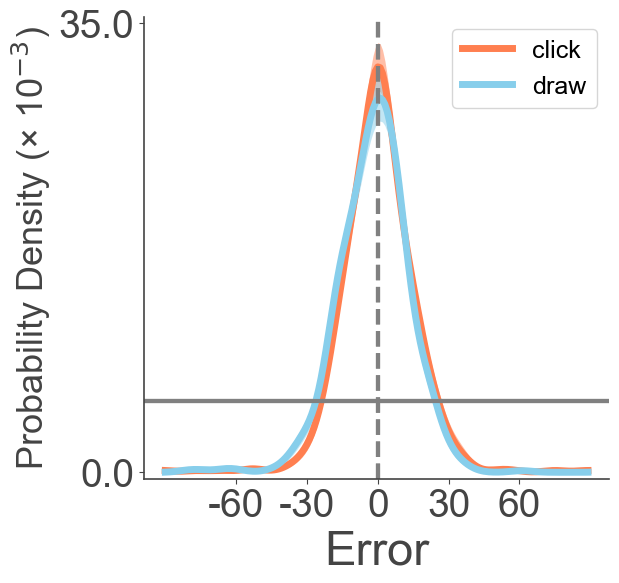

In [92]:
fig, ax = plt.subplots(1, figsize=(6, 6))

load1_masks = {
    'click': lambda df: ((df['mode'] == 'click') & (mem_load1_mask(df))).to_numpy(),
    'draw': lambda df: ((df['mode'] == 'draw') & (mem_load1_mask(df))).to_numpy(),
}

load1_CLICK_ACCS = plot_behav_err_distrib(
    ax, lmb=load1_masks['click'], ref_type='target',
    label='click', plot_line_color=MODE_COLORS['click'],
    ylim_max=0.0355)
load1_DRAW_ACCS = plot_behav_err_distrib(
    ax, lmb=load1_masks['draw'], ref_type='target',
    label='draw', plot_line_color=MODE_COLORS['draw'],
    ylim_max=0.0355)

ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=18)



In [93]:
formatted_accs = {
    'click': {'accuracy': load1_CLICK_ACCS},
    'draw': {'accuracy': load1_DRAW_ACCS},
}
display_ttest_rel2_results(formatted_accs, ['click', 'draw'])

Group: accuracy
: normality_p = 0.761
:: ttest: t(35)=-0.47 (p=0.640)
:: wilcoxon: W=316, n=36 (p=0.798)


##### load = 2

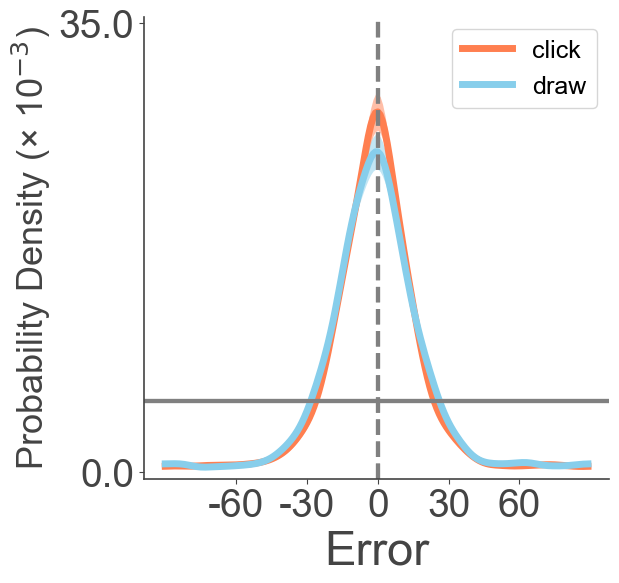

In [94]:
fig, ax = plt.subplots(1, figsize=(6, 6))

load2_masks = {
    'click': lambda df: ((df['mode'] == 'click') & (~mem_load1_mask(df))).to_numpy(),
    'draw': lambda df: ((df['mode'] == 'draw') & (~mem_load1_mask(df))).to_numpy(),
}

load2_CLICK_ACCS = plot_behav_err_distrib(
    ax, lmb=load2_masks['click'], ref_type='target',
    ylim_max=0.0355,
    label='click', plot_line_color=MODE_COLORS['click'])
load2_DRAW_ACCS = plot_behav_err_distrib(
    ax, lmb=load2_masks['draw'], ref_type='target',
    ylim_max=0.0355,
    label='draw', plot_line_color=MODE_COLORS['draw'])

ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=18)


In [95]:
formatted_accs = {
    'click': {'accuracy': load2_CLICK_ACCS},
    'draw': {'accuracy': load2_DRAW_ACCS},
}
display_ttest_rel2_results(formatted_accs, ['click', 'draw'])

Group: accuracy
: normality_p = 0.692
:: ttest: t(35)=-0.62 (p=0.537)
:: wilcoxon: W=298, n=36 (p=0.592)


In [96]:
from statsmodels.formula.api import mixedlm

performance_metric_conds = [
    (load1_CLICK_ACCS, 1, 'wheel'),
    (load1_DRAW_ACCS, 1, 'draw'),
    (load2_CLICK_ACCS, 2, 'wheel'),
    (load2_DRAW_ACCS, 2, 'draw'),
]

def anova_test_behav_performance(conds, metric_name):
    dfs = []
    for d, load, mode in conds:
        df = pd.DataFrame.from_dict(d, orient='index', columns=[metric_name])
        df['load'] = load
        df['mode'] = mode
        dfs.append(df)

    result = pd.concat(dfs)
    result.index.name = 'subject'
    result.reset_index(inplace=True)

    # mixed effects model
    model = mixedlm(f"{metric_name} ~ C(load) * C(mode)", data=result, groups=result["subject"])
    fit = model.fit()

    print(fit.summary())

    

In [97]:
anova_test_behav_performance(
    performance_metric_conds, 'sharpness'
)

                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      sharpness
No. Observations:        144          Method:                  REML     
No. Groups:              36           Scale:                   0.1176   
Min. group size:         4            Log-Likelihood:          -79.7908 
Max. group size:         4            Converged:               Yes      
Mean group size:         4.0                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      5.805    0.075 77.343 0.000  5.658  5.952
C(load)[T.2]                   0.116    0.081  1.437 0.151 -0.042  0.275
C(mode)[T.wheel]              -0.034    0.081 -0.422 0.673 -0.193  0.124
C(load)[T.2]:C(mode)[T.wheel] -0.004    0.114 -0.038 0.970 -0.228  0.

#### as a tuning function of stims

In [98]:
def get_stim_restrict_bias(common_lmb, center_sample, window_size):
    # collect errors
    err_dfs = []

    for subj in all_subjs:
        if subj in invalid_subjs:
            continue
        subj_df = load_subj_behav_data(subj)
        err_dfs.append(df_to_errs(subj_df, common_lmb))
    err_dfs = pd.concat(err_dfs, axis=0, ignore_index=True)

    # masked out by stims
    if window_size is not None:
        stim_within_range_mask = (
            np.abs(deg_signed_diff(err_dfs['stim'].values -center_sample)) <= window_size)
        err_dfs = err_dfs[stim_within_range_mask]

    # grouped by subject
    subj_accs = {}
    subj_bias = {}

    for subj, subjdf in err_dfs.groupby('subject'):
        # collect errors
        distrib = errdf_to_distrib(subjdf, T=180)
        # compute accuracy and bias
        acc = compute_accuracy(distrib, T=180)
        bias = compute_bias(distrib, T=180)
        # collect results
        subj_accs[subj] = acc
        subj_bias[subj] = bias

    return subj_accs, subj_bias

from utils.stats_test import sem_func

def display_acc_bias_as_tuning(common_lmb, condition_name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sample_step = 15
    sample_xs = np.arange(int(180/sample_step)) * sample_step
    collected_sample_stats = []
    for sample_x in sample_xs:
        accs, biases = get_stim_restrict_bias(
            common_lmb=common_lmb,
            center_sample=sample_x,
            window_size=sample_step/2, # to match the gaze analysis
        )
        acc_mean = np.mean(list(accs.values()))
        acc_sem = sem_func(list(accs.values()))
        bias_mean = np.mean(list(biases.values()))
        bias_sem = sem_func(list(biases.values()))
        collected_sample_stats.append({
            'accuracy': {
                'mean': acc_mean,
                'sem': acc_sem,
            },
            'bias': {
                'mean': bias_mean,
                'sem': bias_sem,
            }
        })

    sample_xs = np.append(sample_xs, 180)
    collected_sample_stats.append(collected_sample_stats[0])
        
    for i, stat_name in enumerate(['accuracy', 'bias']):
        stats_mean = np.array([
            collected_sample_stats[i][stat_name]['mean'] for i in range(len(sample_xs))])
        stats_sem = np.array([
            collected_sample_stats[i][stat_name]['sem'] for i in range(len(sample_xs))])
        axs[i].errorbar(sample_xs, stats_mean, yerr=stats_sem, fmt='o', capsize=5)

        axs[i].set_xlabel('Stim Degree')
        axs[i].axvline(45, color='gray', linestyle='--', alpha=0.5)
        axs[i].axvline(90, color='gray', linestyle='--')
        axs[i].axvline(135, color='gray', linestyle='--', alpha=0.5)
        axs[i].axhline(0, color='red', linestyle='--')

        axs[i].set_xticks(sample_xs)

    axs[0].set_ylim([0, 3.5])
    # axs[0].set_yticks(np.arange(-0.1, 1.3, 0.2))
    axs[0].set_ylabel('accuracy', fontsize=14)
    axs[1].set_ylim([-2, 2])
    # axs[1].set_yticks(np.arange(-0.2, 0.3, 0.1))
    axs[1].set_ylabel('bias', fontsize=14)

    # save the result
    plt.tight_layout()
    plot_path = os.path.join(
        PLOTS_FOLDER, f'cardinal_oblique_{condition_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

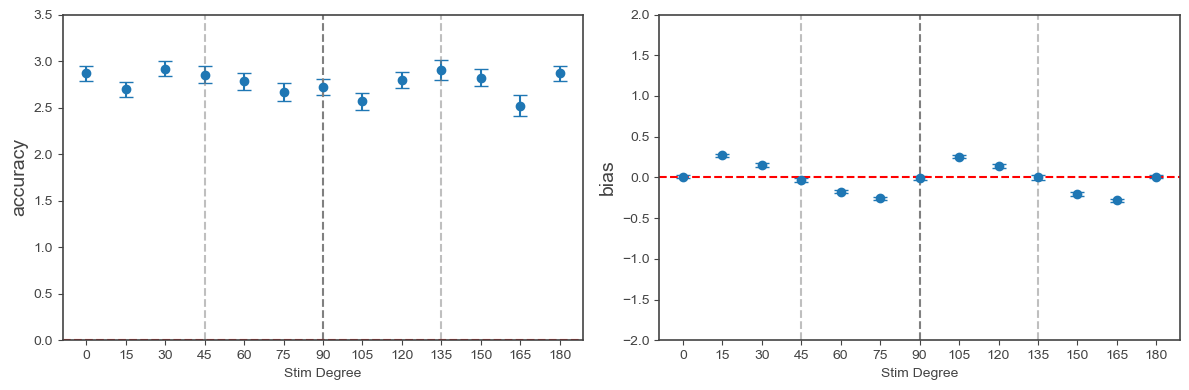

In [99]:
default_lmb = lambda d: np.ones(d.shape[0], dtype=bool)
display_acc_bias_as_tuning(default_lmb, 'all')

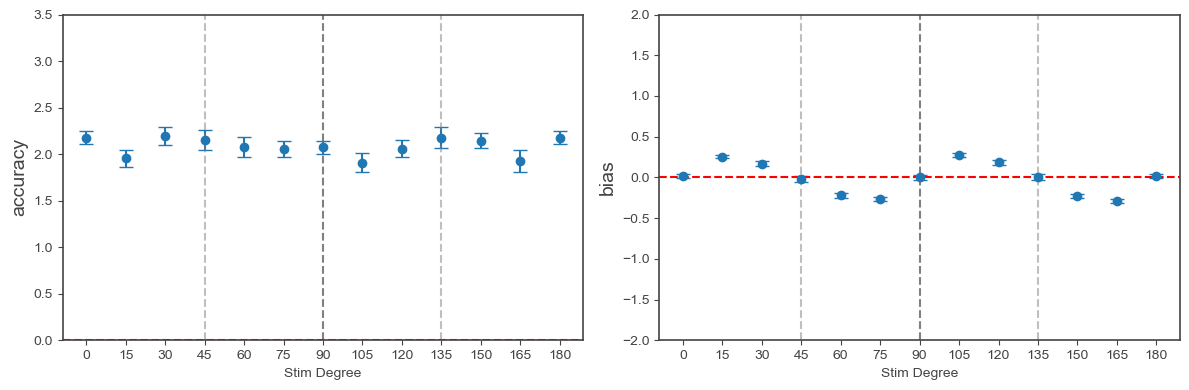

In [100]:
display_acc_bias_as_tuning(draw_lmb, 'draw')

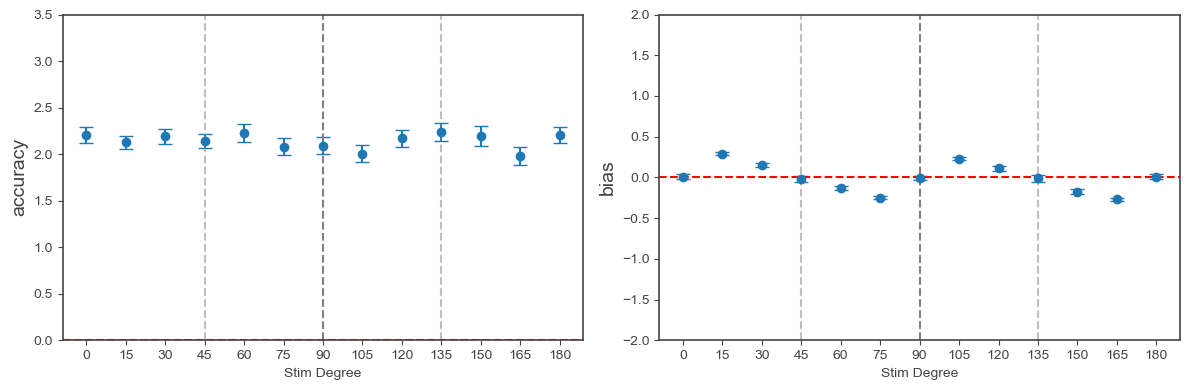

In [101]:
display_acc_bias_as_tuning(click_lmb, 'click')

### Show cardinal / oblique bias as a function

In [102]:
from utils.behav_analysis_helper import errdf_to_stim_distrib

def plot_behav_bias_stim_distrib(
        ax, lmb=None, ref_type=None, to_flip=False,
        **kwargs):
    
    ref = {
        'target': None,
        'previous': 'prev_resp',
        'nontarget': 'non_target',
    }[ref_type]

    es = deg_signed_diff(np.arange(180))
    es[es > 30] = 0 # mask out the big errors

    if to_flip:
        es = np.abs(es)

    # collect subject data
    subj_names = []
    subj_data = []
    for subj in all_subjs:
        behav_data = load_subj_behav_data(subj)
        err_df = df_to_errs(behav_data, lmb)
        distrib = errdf_to_stim_distrib(err_df, ref=ref)

        if len(distrib) == 0:
            continue

        # apply smoothing
        distrib = np.dot(
            SMOOTHING_WEIGHTS, distrib)
        distrib = distrib / np.sum(distrib, axis=1, keepdims=True)

        # compute average errors
        err_curve = np.sum(es * distrib, axis=-1)

        subj_names.append(int(subj))
        subj_data.append(err_curve)

    # plot the result
    subj_mean = np.mean(subj_data, axis=0)
    subj_sem = sem_func(subj_data, axis=0)

    # plot
    ax.plot(
        np.arange(180), subj_mean,
        label=kwargs.get('label'), 
        color=kwargs.get('color'), 
        alpha=1.0)
    ax.fill_between(
        np.arange(180), 
        subj_mean - subj_sem, 
        subj_mean + subj_sem,
        color=kwargs.get('color'), 
        alpha=0.5)

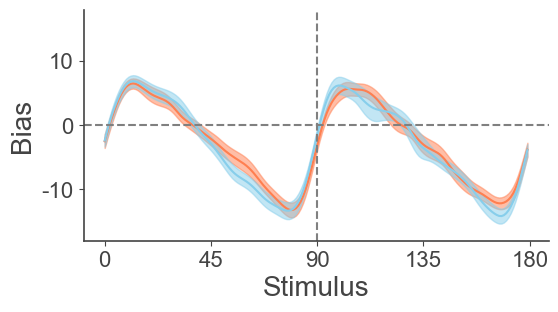

In [103]:
fig, ax = plt.subplots(1, figsize=(6, 3))

plot_behav_bias_stim_distrib(
    ax, lmb=click_lmb, ref_type='target',
    label='click', color=MODE_COLORS['click'])
plot_behav_bias_stim_distrib(
    ax, lmb=draw_lmb, ref_type='target',
    label='draw', color=MODE_COLORS['draw'])

ax.set_xlabel('Stimulus', fontsize=20)
ax.set_ylabel('Bias', fontsize=20)
ax.set_ylim([-18, 18])
xticks = np.arange(5) * 45
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=16)
yticks = np.arange(-1, 2, 1) * 10
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=16)
ax.axhline(0, color='gray', linestyle='--')
ax.axvline(90, color='gray', linestyle='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=16)

#### Error as a function of stim

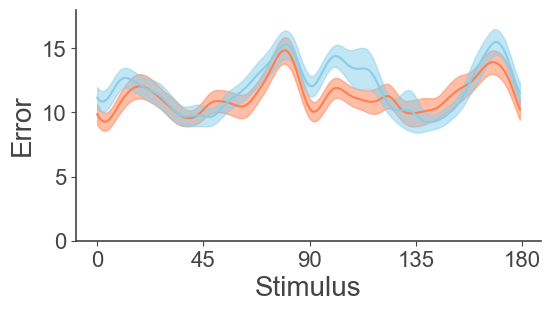

In [104]:
fig, ax = plt.subplots(1, figsize=(6, 3))

plot_behav_bias_stim_distrib(
    ax, lmb=click_lmb, ref_type='target', to_flip=True,
    label='click', color=MODE_COLORS['click'])
plot_behav_bias_stim_distrib(
    ax, lmb=draw_lmb, ref_type='target', to_flip=True,
    label='draw', color=MODE_COLORS['draw'])

ax.set_xlabel('Stimulus', fontsize=20)
ax.set_ylabel('Error', fontsize=20)
ax.set_ylim([0, 18])
xticks = np.arange(5) * 45
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=16)
yticks = np.arange(4) * 5
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#### As a function of stim difference

In [105]:
from utils.behav_analysis_helper import errdf_to_stim_distrib

def plot_behav_err_stim_diff_distrib(ax, lmb=None, **kwargs):
    es = deg_signed_diff(np.arange(180))
    es = np.abs(es)  # use absolute error
    es[es > 30] = 0 # remove error too large

    # collect subject data
    subj_names = []
    subj_data = []
    for subj in all_subjs:
        behav_data = load_subj_behav_data(subj)
        err_df = df_to_errs(behav_data, lmb)

        diffs = deg_signed_diff(
            err_df['non_target'] - err_df['stim']).values
        diffs = np.round(diffs).astype(int) % 180
        errs = err_df['err'].values
        errs = np.round(errs).astype(int) % 180

        subj_freq = np.zeros((180, 180))
        np.add.at(subj_freq, (diffs, errs), 1)

        # smoothing
        distrib = np.dot(SMOOTHING_WEIGHTS, subj_freq)
        distrib = distrib / np.sum(distrib, axis=1, keepdims=True)

        # compute average errors
        err_curve = np.sum(es * distrib, axis=-1)

        subj_names.append(int(subj))
        subj_data.append(err_curve)

    # plot the result
    subj_mean = np.mean(subj_data, axis=0)
    subj_sem = sem_func(subj_data, axis=0)

    plot_xs = deg_signed_diff(np.arange(180))
    sort_ids = np.argsort(plot_xs)

    # plot
    ax.plot(
        plot_xs[sort_ids], subj_mean[sort_ids],
        label=kwargs.get('label'), 
        color=kwargs.get('color'), 
        alpha=1.0)
    ax.fill_between(
        plot_xs[sort_ids], 
        (subj_mean - subj_sem)[sort_ids], 
        (subj_mean + subj_sem)[sort_ids],
        color=kwargs.get('color'), 
        alpha=0.5)
    ax.set_xlabel(r'\|s_1 - s_2\|')
    ax.set_ylabel(r'\|e_1 - e_2\|')
    

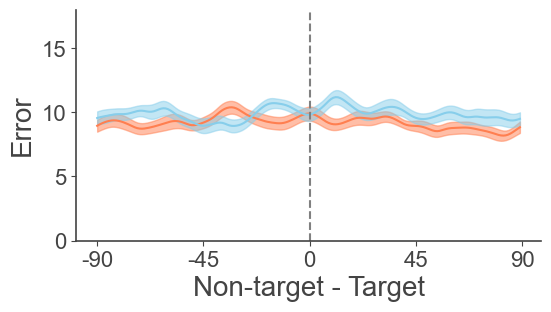

In [106]:
fig, ax = plt.subplots(1, figsize=(6, 3))

plot_behav_err_stim_diff_distrib(
    ax, lmb=click_lmb, 
    label='click', color=MODE_COLORS['click'])
plot_behav_err_stim_diff_distrib(
    ax, lmb=draw_lmb, 
    label='draw', color=MODE_COLORS['draw'])

ax.set_xlabel('Non-target - Target', fontsize=20)
ax.set_ylabel('Error', fontsize=20)
ax.set_ylim([0, 18])
xticks = np.arange(-2, 3) * 45
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=16)
yticks = [0, 5, 10, 15]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=16)
ax.axvline(0, color='gray', linestyle='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Get subjectwise behavior stats

In [107]:
from utils.behav_analysis_helper import subj_behav_df_to_stats

def compute_subj_behav_stats(lmb, stat_type):
    collected = {}
    for subj in all_subjs:
        if subj in invalid_subjs:
            continue
        subj_df = load_subj_behav_data(subj)
        stats = subj_behav_df_to_stats(
            subj_df, lmb,
            stim1_lmb=None, stim2_lmb=None,
            stat_type=stat_type)
        if stats is None:
            # subject do not have enough data...
            continue
        collected[subj] = stats

    return collected

#### Firstly, check accuracy

In [108]:
subj_acc_stats = compute_subj_behav_stats(default_lmb, 'accuracy')
subj_draw_accs = compute_subj_behav_stats(draw_lmb, 'accuracy')
subj_click_accs = compute_subj_behav_stats(click_lmb, 'accuracy')

In [109]:
import statsmodels.api as sm

def display_regression(ax, l1, l2, line_color=None):
    x_with_const = sm.add_constant(l1)
    model = sm.OLS(l2, x_with_const).fit()
    predictions = model.get_prediction(x_with_const)
    summary_frame = predictions.summary_frame(alpha=0.05)

    # Get confidence intervals of the model
    conf_int = model.conf_int(alpha=0.05)

    # Get standard errors
    y_pred = summary_frame['mean']                 # Predicted values
    ci_lower = summary_frame['mean_ci_lower']      # Lower bound of confidence interval
    ci_upper = summary_frame['mean_ci_upper']

    # also get estimate of parameters
    params = model.params

    # plot it
    order = np.argsort(l1)
    line_color = line_color if line_color is not None else '#333333'
    ax.plot(
        l1[order], y_pred[order], color=line_color, 
        label=f'Regression Line: y={model.params[1]:.2f}x+{model.params[0]:.2f}',
        linewidth=4, alpha=0.5)
    ax.fill_between(l1[order], ci_lower[order], ci_upper[order], color='lightgray', alpha=0.3)

    # show p value
    p_values = model.pvalues
    # print(p_values)
    return conf_int, p_values, params

def display_regression_with_plot(
        l1, l2, xlabel, ylabel, plot_name, 
        show_conf_int=False, mark_median=True,
        line_color=None, dot_color=None):
    _, ax = plt.subplots(1, figsize=(4, 4))
    label_fontsize = 18
    # regression
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    conf_int, pval, params = display_regression(ax, l1, l2, line_color=line_color)
    ax.set_title(f'p-val: {pval[1]:.4f}')

    # scatter plot
    dot_color = dot_color if dot_color is not None else '#AAAAAA'
    dot_size = 100
    ax.scatter(
        l1, l2, facecolor=dot_color, 
        edgecolor='#666666', alpha=0.7, s=dot_size)

    # also mark the median
    if mark_median:
        median_x = np.median(l1)
        median_y = np.median(l2)
        ax.axvline(median_x, color='gray', alpha=0.5, linestyle='--')
        ax.axhline(median_y, color='gray', alpha=0.5, linestyle='--')

    plot_path = os.path.join(
        PLOTS_FOLDER, f'{plot_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # print confidence intervals
    if show_conf_int:
        print(f'Estimate: {params}')
        print(f'Confidence intervals: {conf_int}')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return ax

def dispalay_regression_dicts(
        dict1, dict2, xlabel, ylabel, plot_name, show_conf_int=False, mark_median=True,
        l1_cutoff=None, l2_cutoff=None):
    shared_keys = set(dict1.keys()).intersection(set(dict2.keys()))
    l1 = np.array([dict1[k] for k in shared_keys])
    l2 = np.array([dict2[k] for k in shared_keys])

    if l1_cutoff is not None:
        l1 = np.maximum(l1, l1_cutoff)
    if l2_cutoff is not None:
        l2 = np.maximum(l2, l2_cutoff)

    ax = display_regression_with_plot(
        l1, l2, xlabel, ylabel, plot_name, show_conf_int=show_conf_int, mark_median=mark_median)
    return ax

##### load gaze acc

In [110]:
gaze_stats_path = os.path.join(
    RESULTS_PATH, 'stats', 'gaze', 'inverted_enc')

In [111]:
DEFAULT_BEHAV_THRESH = 3.5
DEFAULT_GAZE_THRESH = 0.0

In [112]:
def load_acc_stats(gaze_stats_name, stim_name='combined'):
        gaze_acc_path = os.path.join(gaze_stats_path, gaze_stats_name, 'accuracy.json')
        with open(gaze_acc_path) as f:
                gaze_acc = json.load(f)
        if stim_name in gaze_acc:
                gaze_acc = gaze_acc[stim_name]['accuracy']
        else:
                gaze_acc = gaze_acc['stim 1']['accuracy']
        return gaze_acc

def compare_gaze_behav_acc(gaze_stats_name, behav_stats, plot_name,
                gaze_acc_thresh=DEFAULT_GAZE_THRESH, behav_acc_thresh=DEFAULT_BEHAV_THRESH):
        gaze_acc = load_acc_stats(gaze_stats_name)
        # filter by accuracy
        gaze_acc = {k: v for k, v in gaze_acc.items() if v > gaze_acc_thresh}
        behav_stats = {k: v for k, v in behav_stats.items() if v > behav_acc_thresh}

        # compare gaze and behav
        dispalay_regression_dicts(
                gaze_acc, behav_stats,
                'Gaze Accuracy', 'Behavior Accuracy',
                plot_name)


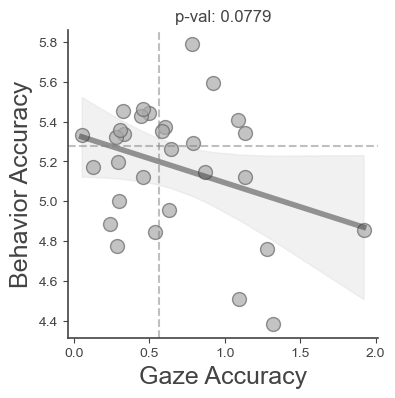

In [113]:
compare_gaze_behav_acc(
    'enc1_after_cue_combined', subj_acc_stats, 'reg_behav_gaze_enc_acc')

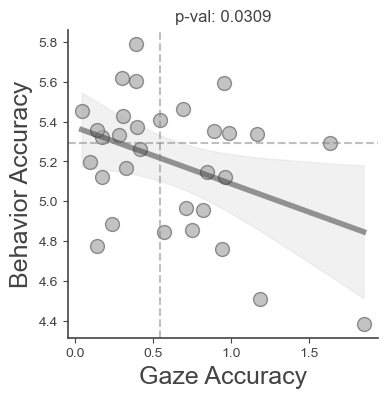

In [114]:
compare_gaze_behav_acc(
    'whole_isi_combined', subj_acc_stats, 'reg_behav_gaze_isi_acc')

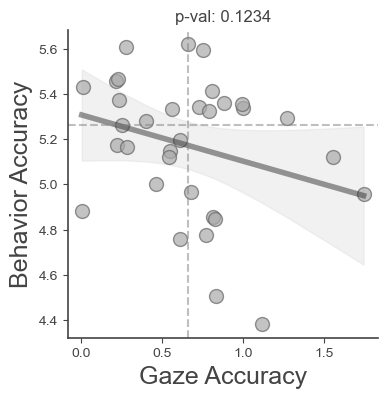

In [115]:
compare_gaze_behav_acc(
    'whole_delay_combined', subj_acc_stats, 'reg_behav_gaze_delay_acc')

### what about across phase decoding?

In [116]:
enc_isi_generalizability = {}
gaze_enc_acc = load_acc_stats('enc1_after_cue_combined')
gaze_isi_acc = load_acc_stats('whole_isi_combined')
gaze_enc_isi_acc = load_acc_stats('enc1_isi_combined')
gaze_enc_acc_cutoff = np.percentile(list(gaze_enc_acc.values()), 30)
gaze_isi_acc_cutoff = np.percentile(list(gaze_isi_acc.values()), 30)
print(gaze_enc_acc_cutoff, gaze_isi_acc_cutoff)
for k in gaze_enc_acc.keys():
    if (gaze_enc_acc[k] < gaze_enc_acc_cutoff) or (gaze_isi_acc[k] < gaze_isi_acc_cutoff):
        continue
    enc_isi_generalizability[k] = gaze_enc_isi_acc[k] / np.sqrt(
        gaze_enc_acc[k] * gaze_isi_acc[k])

0.2968171692535815 0.26107900813137364


<Axes: title={'center': 'p-val: 0.7115'}, xlabel='Enc -> ISI Generalizability', ylabel='Behavior Accuracy'>

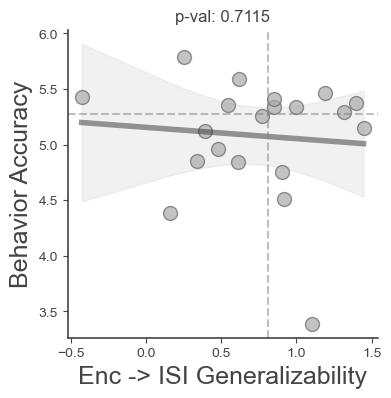

In [117]:
dispalay_regression_dicts(
    enc_isi_generalizability, 
    subj_acc_stats,
    'Enc -> ISI Generalizability', 
    'Behavior Accuracy', 
    'reg_enc_isi_gen_vs_behav_acc')

In [118]:
isi_delay_generalizability = {}
gaze_delay_acc = load_acc_stats('whole_delay_combined')
gaze_isi_delay_acc = load_acc_stats('isi_delay_combined')
gaze_isi_acc_cutoff = np.percentile(list(gaze_isi_acc.values()), 30)
gaze_delay_acc_cutoff = np.percentile(list(gaze_delay_acc.values()), 30)
for k in gaze_isi_acc.keys():
    if (gaze_isi_acc[k] < gaze_isi_acc_cutoff) or (gaze_delay_acc[k] < gaze_delay_acc_cutoff):
        continue
    gen_val = gaze_isi_delay_acc[k] / np.sqrt(
        gaze_isi_acc[k] * gaze_delay_acc[k])
    isi_delay_generalizability[k] = gen_val

<Axes: title={'center': 'p-val: 0.0066'}, xlabel='ISI -> Delay Generalizability', ylabel='Behavior Accuracy'>

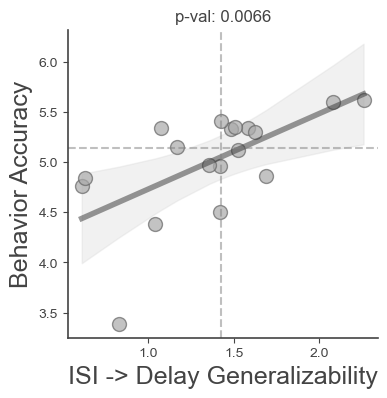

In [119]:
dispalay_regression_dicts(
    isi_delay_generalizability, 
    subj_acc_stats,
    'ISI -> Delay Generalizability', 
    'Behavior Accuracy', 
    'reg_isi_delay_gen_vs_behav_acc')

#### Now examine whether gaze/behavior draw/wheel accuracy interact

In [120]:
def load_hand_stats(stim_name, result_name='whole_delay_combined'):
        acc_file_path = os.path.join(
                RESULTS_PATH, 'stats', 'hand', 'inverted_enc', 
                result_name, 'accuracy.json')
        with open(acc_file_path) as f:
                hand_acc = json.load(f)
        hand_acc = hand_acc[stim_name]['accuracy']
        return hand_acc

In [121]:
hand_draw_acc_combined = load_hand_stats('draw')
hand_click_acc_combined = load_hand_stats('click')
gaze_draw_acc_combined = load_acc_stats('whole_delay_combined', 'draw')
gaze_click_acc_combined = load_acc_stats('whole_delay_combined', 'click')

In [122]:
metric_dicts = {
    'hand_draw': hand_draw_acc_combined,
    'hand_click': hand_click_acc_combined,
    'gaze_draw': gaze_draw_acc_combined,
    'gaze_click': gaze_click_acc_combined,
}

# Combine into one DataFrame
metric_2x2_df = pd.DataFrame(metric_dicts)

In [123]:
# remove 908 that should be the pilot subject
# metric_2x2_df = metric_2x2_df[metric_2x2_df.index != '908']

**comments**: since evidence < 0 does not make sense...in the following analysis all negative evidence are converted to 0 (invalid, no-evidence). Since we are only doing pairwise comparison and comparing the differences it should not matter.

In [ ]:
TO_CONVERT_NEG = False

In [125]:
# metric_2x2_cleaned = metric_2x2_df[metric_2x2_df.gt(-0.0).all(axis=1)]
metric_2x2_cleaned = metric_2x2_df.copy()
if TO_CONVERT_NEG:
    metric_2x2_cleaned[metric_2x2_cleaned < 0] = 0.0

In [126]:
from utils.stats_test import default_paired_test, sem_func, paired_test_to_str

def get_wilcoxon_stats_range(s):
    med = s.median()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    return f"Mdn (Q1, Q3): {med:.2f} ({q1:.2f}, {q3:.2f})"

def get_ttest_stats_range(s):
    mean = s.mean()
    sem = sem_func(s)
    return f"M \u00B1 SEM: {mean:.2f}\u00B1{sem:.2f}"

test_type_additional_map = {
    'ttest': get_ttest_stats_range,
    'wilcoxon': get_wilcoxon_stats_range,
}

def display_specific_test_result(test_type, s1, s2, s1_name, s2_name):
    additional_test = test_type_additional_map[test_type]
    s1_stats = additional_test(s1)
    s2_stats = additional_test(s2)
    paired_test = default_paired_test(s1, s2, default_test_type=test_type)
    paired_test_str = paired_test_to_str(paired_test)

    # normality check result
    if test_type == 'ttest':
        normality_p = paired_test['normality_p']
        paired_test_str += f' (normality p={normality_p:.3f})'

    # display results
    print(f"Results for {s1_name} vs {s2_name} ({test_type}):")
    print(f"  {s1_name}: {s1_stats}")
    print(f"  {s2_name}: {s2_stats}")
    print(f"  Paired test: {paired_test_str}\n")


def display_all_paired_test_result(s1, s2, s1_name, s2_name):
    for test_type in ['ttest', 'wilcoxon',]:
        display_specific_test_result(
            test_type, s1, s2, s1_name, s2_name)   


In [127]:
def change_violin_plot_color(vp, color):
    for body in vp['bodies']:
        body.set_color(color)
    vp['cbars'].set_color(color)
    vp['cmins'].set_color(color)
    vp['cmaxes'].set_color(color)
    vp['cmeans'].set_color(color)

def plot_paired_data(df, c1, c2, c1_name, c2_name, c1_color, c2_color, 
        show_pair=False, show_viloin=False, mark_center=True, scatter_alpha=0.7,
        jitter_scale=0.1):
    fig, ax = plt.subplots(figsize=(2.5, 4))

    # jittering
    np.random.seed(42)
    jitter1 = np.random.uniform(low=-1, high=1, size=len(df)) * jitter_scale
    jitter2 = np.random.uniform(low=-1, high=1, size=len(df)) * jitter_scale
    x1 = np.zeros(len(df)) + jitter1
    x2 = np.ones(len(df)) + jitter2

    df = df.copy()
    df['x1'] = x1
    df['x2'] = x2

    # apply stats test and display results
    display_all_paired_test_result(
        df[c1], df[c2], 
        s1_name=c1_name, s2_name=c2_name)

    # mark the center
    mean_as_center = False # since we use wilcoxon, default is to mark the median
    if mark_center:
        bar_w, bar_width = 0.4, 4
        center_1 = df[c1].mean() if mean_as_center else df[c1].median()
        center_2 = df[c2].mean() if mean_as_center else df[c2].median()
        ax.hlines(y=center_1, xmin=0-bar_w, xmax=0+bar_w, 
            color=c1_color, linewidth=bar_width)
        ax.hlines(y=center_2, xmin=1-bar_w, xmax=1+bar_w,
            color=c2_color, linewidth=bar_width)
    
    if show_pair:
        # paired
        for _, row in df.iterrows():
            ax.plot(
                [row['x1'], row['x2']], 
                [row[c1], row[c2]],
                linewidth=2, color='gray', alpha=0.5)

    # scatter
    dotsize = 8
    ax.plot(
        df['x1'], df[c1], 
        marker='o', linestyle='',
        markeredgecolor='gray', markersize=dotsize,
        color=c1_color, alpha=scatter_alpha)
    ax.plot(
        df['x2'], df[c2], 
        marker='o', linestyle='',
        markeredgecolor='gray', markersize=dotsize,
        color=c2_color, alpha=scatter_alpha)

    # violin plots
    if show_viloin:
        vp = ax.violinplot(
            df[c1], 
            positions=[0-jitter_scale], showmeans=True, 
            side='low')
        change_violin_plot_color(vp, c1_color)

        vp = ax.violinplot(
            df[c2], 
            positions=[1+jitter_scale], showmeans=True, 
            side='high')
        change_violin_plot_color(vp, c2_color)

    # fix x-axis
    ax.set_xticks([0, 1])
    ax.set_xticklabels([c1_name, c2_name], fontsize=18)
    ax.set_xlim([-0.5, 1.5])
    ax.axhline(0, linestyle='--', color='gray', linewidth=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return ax

In [128]:
mode_d_df_dict = {}
for mode in ['hand', 'gaze']:
    mode_draw_scores = metric_2x2_cleaned[f'{mode}_draw'].to_numpy(copy=True)
    mode_click_scores = metric_2x2_cleaned[f'{mode}_click'].to_numpy(copy=True)
    if TO_CONVERT_NEG:
        mode_draw_scores[mode_draw_scores < 0] = 0.0
        mode_click_scores[mode_click_scores < 0] = 0.0
    mode_d_df_dict[f'd_{mode}'] = mode_draw_scores - mode_click_scores

mode_d_df = pd.DataFrame(mode_d_df_dict)

Results for Gaze vs Hand (ttest):
  Gaze: M ± SEM: -0.25±0.11
  Hand: M ± SEM: 0.15±0.05
  Paired test: t(35)=-2.87 (p=0.007) (normality p=0.926)

Results for Gaze vs Hand (wilcoxon):
  Gaze: Mdn (Q1, Q3): -0.36 (-0.80, 0.26)
  Hand: Mdn (Q1, Q3): 0.14 (-0.04, 0.28)
  Paired test: W=165, n=36 (p=0.007)

$r=-0.404$,$p=0.0145$


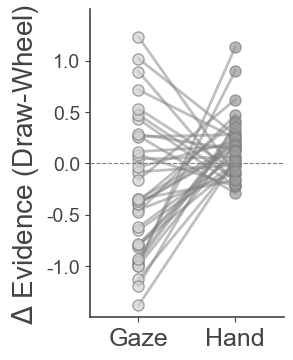

In [129]:
# Plot
ax = plot_paired_data(
    mode_d_df, 
    c1='d_gaze', c2='d_hand', 
    c1_name='Gaze', c2_name='Hand',
    c1_color='lightgray', c2_color='#999999',
    show_pair=True, mark_center=False,
    jitter_scale=0,
)

ax.set_ylim([-1.5, 1.5])
yticks = [-1.0, -0.5, 0.0, 0.5, 1.0]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=14)
ax.set_ylabel(r'$\Delta$ Evidence (Draw-Wheel)', fontsize=20)

# run correlation test
from scipy.stats import pearsonr

r, p = pearsonr(
    mode_d_df['d_gaze'], 
    mode_d_df['d_hand'])

print(f"$r={r:.3f}$,$p={p:.4f}$")


Estimate: [ 0.10906218 -0.18222505]
Confidence intervals: [[ 0.00746481  0.21065955]
 [-0.32593549 -0.0385146 ]]


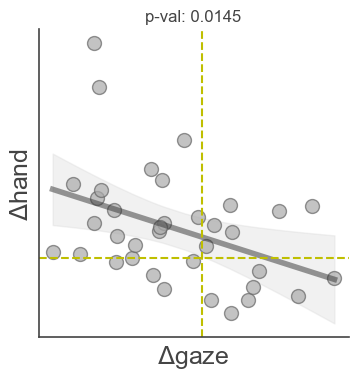

In [130]:
# plot the correlation

ax = display_regression_with_plot(
    mode_d_df['d_gaze'].values, mode_d_df['d_hand'].values, 
    r"$\Delta$gaze",  r"$\Delta$hand", 'mode_delta_regression', 
    show_conf_int=True, mark_median=False)
# ax.set_ylim([-2, 2])
# ax.set_xlim([-2, 2])
# ax.set_yticks([-2, 0, 2])
# ax.set_xticks([-2, 0, 2])
ax.set_xticks([])
ax.set_yticks([])
ax.axhline(0, color='y', linestyle='--')
ax.axvline(0, color='y', linestyle='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


Estimate: [ 0.10906218 -0.18222505]
Confidence intervals: [[ 0.00746481  0.21065955]
 [-0.32593549 -0.0385146 ]]


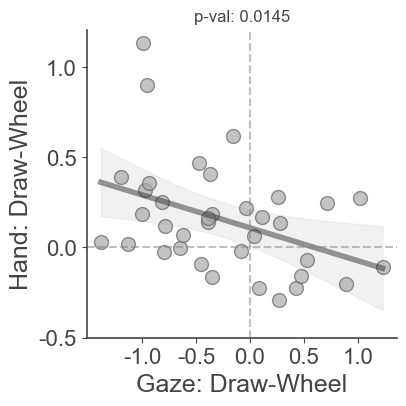

In [131]:
# plot the correlation

ax = display_regression_with_plot(
    mode_d_df['d_gaze'].values, mode_d_df['d_hand'].values,
    "Gaze: Draw-Wheel", "Hand: Draw-Wheel", 'mode_delta_regression_ver2', 
    show_conf_int=True, mark_median=False)

ax_max = 1.5
# ax.set_ylim([-ax_max, ax_max])
# ax.set_xlim([-ax_max, ax_max])

# set ticks
tick_size=16
x_ticks = [-1.0, -0.5, 0.0, 0.5, 1.0]
ax.set_xticks(x_ticks)
ax.set_xticklabels([f"{x:.1f}" for x in x_ticks], fontsize=tick_size)
y_ticks = [-0.5, 0.0, 0.5, 1.0]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{y:.1f}" for y in y_ticks], fontsize=tick_size)

# set grid
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


##### use the same code to plot the distribution of accuracy

In [132]:
draw_behav_acc_df = pd.DataFrame.from_dict(
    DRAW_ACCS, orient='index', columns=['draw'])
click_behav_acc_df = pd.DataFrame.from_dict(
    CLICK_ACCS, orient='index', columns=['click'])
behav_acc_df = pd.merge(
    draw_behav_acc_df, click_behav_acc_df, 
    left_index=True, right_index=True,
    how='inner')

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 5.97±0.08
  Wheel: M ± SEM: 5.92±0.07
  Paired test: t(35)=0.89 (p=0.378) (normality p=0.854)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 6.06 (5.81, 6.30)
  Wheel: Mdn (Q1, Q3): 5.99 (5.79, 6.18)
  Paired test: W=278, n=36 (p=0.396)



Text(0, 0.5, 'Sharpness')

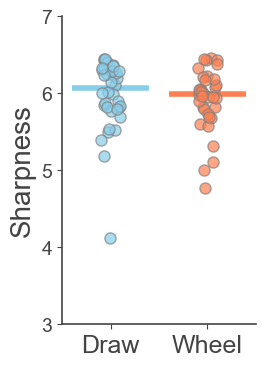

In [133]:
# Plot
ax = plot_paired_data(
    behav_acc_df, 
    c1='draw', c2='click', 
    c1_name='Draw', c2_name='Wheel',
    c1_color=MODE_COLORS['draw'], c2_color=MODE_COLORS['click'],
    show_pair=False, mark_center=True,
    jitter_scale=0.1,
)

ax.set_ylim([3.8, 6.8])
yticks = [3, 4, 5, 6, 7]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=14)
ax.set_ylabel('Sharpness', fontsize=20)


##### repeat for load=1 v.s. load=2

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 5.80±0.07
  Wheel: M ± SEM: 5.77±0.07
  Paired test: t(35)=0.47 (p=0.640) (normality p=0.761)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 5.89 (5.43, 6.10)
  Wheel: Mdn (Q1, Q3): 5.80 (5.52, 6.11)
  Paired test: W=316, n=36 (p=0.798)

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 5.92±0.08
  Wheel: M ± SEM: 5.88±0.07
  Paired test: t(35)=0.62 (p=0.537) (normality p=0.692)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 5.98 (5.74, 6.28)
  Wheel: Mdn (Q1, Q3): 5.96 (5.71, 6.12)
  Paired test: W=298, n=36 (p=0.592)



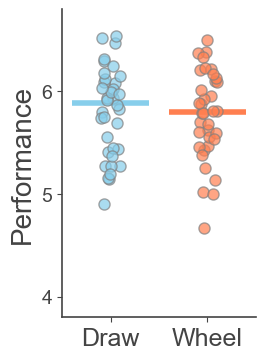

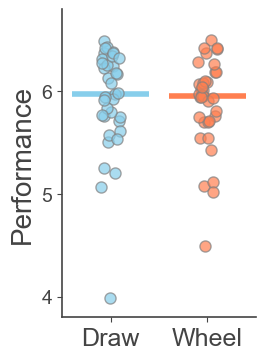

In [134]:
# Plot
load_perf_results = {
    '1': {
        'click': load1_CLICK_ACCS,
        'draw': load1_DRAW_ACCS,
    },
    '2': {
        'click': load2_CLICK_ACCS,
        'draw': load2_DRAW_ACCS,
    },
}

for load in [1, 2]:
    load_draw_behav_acc_df = pd.DataFrame.from_dict(
        load_perf_results[str(load)]['draw'], orient='index', columns=['draw'])
    load_click_behav_acc_df = pd.DataFrame.from_dict(
        load_perf_results[str(load)]['click'], orient='index', columns=['click'])
    load_behav_acc_df = pd.merge(
        load_draw_behav_acc_df, load_click_behav_acc_df, 
        left_index=True, right_index=True,
        how='inner')

    ax = plot_paired_data(
        load_behav_acc_df, 
        c1='draw', c2='click', 
        c1_name='Draw', c2_name='Wheel',
        c1_color=MODE_COLORS['draw'], c2_color=MODE_COLORS['click'],
        show_pair=False, mark_center=True,
        jitter_scale=0.1,
    )

    ax.set_ylim([3.8, 6.8])
    yticks = [4, 5, 6]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=14)
    ax.set_ylabel('Performance', fontsize=20)

In [135]:
# do the same things for errors
def load_subj_err(lmb=None, err_thresh=45):
    # collect subject data
    subj_errs = {}
    for subj in all_subjs:
        behav_data = load_subj_behav_data(subj)
        err_df = df_to_errs(behav_data, lmb)
        errors = err_df['err'].abs().values
        errors = errors[errors <= err_thresh]
        avg_err = np.mean(errors)
        subj_errs[subj] = avg_err

    return subj_errs

In [136]:
draw_behav_errs = load_subj_err(lmb=draw_lmb, err_thresh=45)
click_behav_errs = load_subj_err(lmb=click_lmb, err_thresh=45)

In [137]:
draw_behav_err_df = pd.DataFrame.from_dict(
    draw_behav_errs, orient='index', columns=['draw'])
click_behav_err_df = pd.DataFrame.from_dict(
    click_behav_errs, orient='index', columns=['click'])
behav_err_df = pd.merge(
    draw_behav_err_df, click_behav_err_df, 
    left_index=True, right_index=True,
    how='inner')

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 12.51±0.50
  Wheel: M ± SEM: 11.59±0.43
  Paired test: t(35)=2.95 (p=0.006) (normality p=0.579)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 12.77 (10.33, 14.46)
  Wheel: Mdn (Q1, Q3): 12.02 (10.10, 13.65)
  Paired test: W=171, n=36 (p=0.010)



Text(0, 0.5, 'Error (deg)')

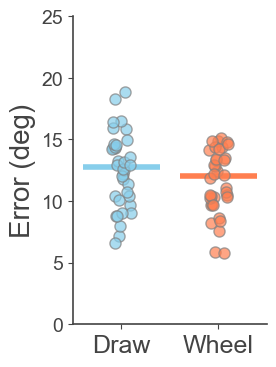

In [138]:
# Plot
ax = plot_paired_data(
    behav_err_df, 
    c1='draw', c2='click', 
    c1_name='Draw', c2_name='Wheel',
    c1_color=MODE_COLORS['draw'], c2_color=MODE_COLORS['click'],
    show_pair=False, mark_center=True,
    jitter_scale=0.1,
)

ax.set_ylim([4, 21])
yticks = [0, 5, 10, 15, 20, 25]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=14)
ax.set_ylabel('Error (deg)', fontsize=20)

##### separate load 1 and load 2

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 11.12±0.49
  Wheel: M ± SEM: 10.47±0.55
  Paired test: t(35)=1.42 (p=0.165) (normality p=0.103)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 10.92 (9.23, 13.26)
  Wheel: Mdn (Q1, Q3): 9.73 (8.38, 12.76)
  Paired test: W=248, n=36 (p=0.187)

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 12.78±0.52
  Wheel: M ± SEM: 11.83±0.45
  Paired test: t(35)=2.68 (p=0.011) (normality p=0.076)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 12.79 (10.60, 14.74)
  Wheel: Mdn (Q1, Q3): 11.81 (10.16, 14.41)
  Paired test: W=181, n=36 (p=0.016)



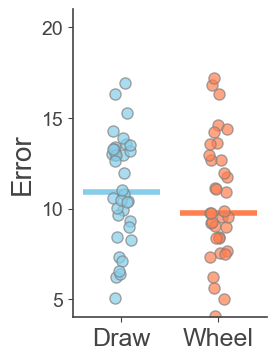

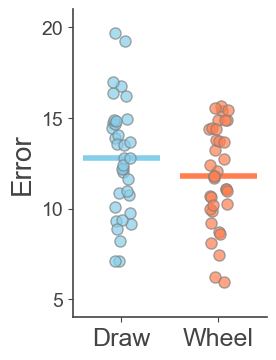

In [139]:
combined_load_masks = [
    lambda df: mem_load1_mask(df),
    lambda df: ~mem_load1_mask(df),
]

err_load_summary = []

for load in [1, 2]:
    select_load_mask = combined_load_masks[load-1]
    loaded_err_df = {}
    for mode in ['draw', 'click']:
        load_mask = lambda df: select_load_mask(df) & (df['mode'] == mode)
        loaded_errs = load_subj_err(lmb=load_mask, err_thresh=45)
        err_load_summary.append((loaded_errs, load, 
            {'draw': 'draw', 'click': 'wheel'}[mode]))
        loaded_err_df[mode] = pd.DataFrame.from_dict(
            loaded_errs, orient='index', columns=[mode])
        
    load_behav_err_df = pd.merge(
        loaded_err_df['draw'], loaded_err_df['click'], 
        left_index=True, right_index=True,
        how='inner')
    
    # Plot
    ax = plot_paired_data(
        load_behav_err_df, 
        c1='draw', c2='click', 
        c1_name='Draw', c2_name='Wheel',
        c1_color=MODE_COLORS['draw'], c2_color=MODE_COLORS['click'],
        show_pair=False, mark_center=True,
        jitter_scale=0.1,
    )

    ax.set_ylim([4, 21])
    yticks = [5, 10, 15, 20]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=14)
    ax.set_ylabel('Error', fontsize=20)

In [140]:
anova_test_behav_performance(
    err_load_summary, 'error'
)

                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      error    
No. Observations:        144          Method:                  REML     
No. Groups:              36           Scale:                   3.4915   
Min. group size:         4            Log-Likelihood:          -328.7390
Max. group size:         4            Converged:               Yes      
Mean group size:         4.0                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     11.120    0.506 21.978 0.000 10.129 12.112
C(load)[T.2]                   1.662    0.440  3.773 0.000  0.798  2.525
C(mode)[T.wheel]              -0.649    0.440 -1.474 0.140 -1.513  0.214
C(load)[T.2]:C(mode)[T.wheel] -0.303    0.623 -0.486 0.627 -1.524  0.

#### Also inspect the timing information

In [141]:
TIMEINFO_FOLDER = os.path.join(
    DEFAULT_DATA_FOLDER, 'behavior', 'subjects_extra'
)

def extract_subj_timing_info(subj, load, stat_name, 
        min_n_response, max_n_response, level):
    loaded = pd.read_csv(
        os.path.join(TIMEINFO_FOLDER, f'{subj}.csv'),
        index_col=0)

    # load mask
    if load is not None:
        loaded = loaded[combined_load_masks[load-1](loaded)]

    # remove no-response
    loaded = loaded[loaded['resp_time_n_responses'] > 0]

    # cap n response
    min_n_response = min_n_response if min_n_response is not None else 0
    max_n_response = max_n_response if max_n_response is not None else 2
    loaded = loaded[loaded['resp_time_n_responses'].between(
        min_n_response, max_n_response)]

    # separate by mode
    extracted = {}
    for mode in ['draw', 'click']:
        mode_mask = loaded['mode'] == mode
        mode_loaded = loaded[mode_mask]

        if level == 0:
            # get mean
            subj_stats = mode_loaded[f'resp_time_{stat_name}'].mean()
        elif level == 1:
            # get median
            subj_stats = mode_loaded[f'resp_time_{stat_name}'].values
        else:
            raise ValueError("Invalid level")

        extracted[mode] = subj_stats

    return extracted


def generate_timing_summary(load, stat_name, 
        min_n_response, max_n_response, y_label, y_max):
    # collect all subject stats
    all_subj_stats = []
    for subj in all_subjs:
        # load timing information
        subj_stats = extract_subj_timing_info(
            subj, load, stat_name, 
            min_n_response, max_n_response, 
            level=0)
        all_subj_stats.append(subj_stats)

    # rename
    all_subj_stats = pd.DataFrame(all_subj_stats)
    all_subj_stats.index = all_subjs
    
    # Plot
    ax = plot_paired_data(
        all_subj_stats, 
        c1='draw', c2='click', 
        c1_name='Draw', c2_name='Wheel',
        c1_color=MODE_COLORS['draw'], c2_color=MODE_COLORS['click'],
        show_pair=False, mark_center=True,
        jitter_scale=0.1,
    )

    ax.set_ylim([0, y_max])
    ytick_step = 1 if isinstance(y_max, int) else 0.5
    yticks = np.arange(0, y_max+ytick_step, ytick_step)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=14)
    ax.set_ylabel(y_label, fontsize=20)

def generate_timing_summary_for_all_loads(
        stat_name, y_label, y_maxs):
    for i, load in enumerate([None, 1, 2]):
        generate_timing_summary(
            load=load, stat_name=stat_name, 
            min_n_response=load, max_n_response=load, 
            y_label=y_label, y_max=y_maxs[i])
        

##### start time...

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 2.32±0.08
  Wheel: M ± SEM: 2.14±0.09
  Paired test: t(35)=2.39 (p=0.022) (normality p=0.004)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 2.37 (2.06, 2.61)
  Wheel: Mdn (Q1, Q3): 2.11 (1.83, 2.40)
  Paired test: W=148, n=36 (p=0.003)

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 2.22±0.10
  Wheel: M ± SEM: 2.01±0.10
  Paired test: t(35)=2.43 (p=0.020) (normality p=0.178)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 2.20 (1.90, 2.56)
  Wheel: Mdn (Q1, Q3): 1.91 (1.61, 2.31)
  Paired test: W=168, n=36 (p=0.009)

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 2.33±0.08
  Wheel: M ± SEM: 2.15±0.10
  Paired test: t(35)=2.15 (p=0.039) (normality p=0.084)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 2.34 (2.11, 2.59)
  Wheel: Mdn (Q1, Q3): 2.14 (1.85, 2.41)
  Paired test: W=175, n=36 (p=0.012)



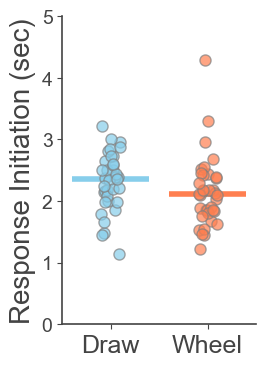

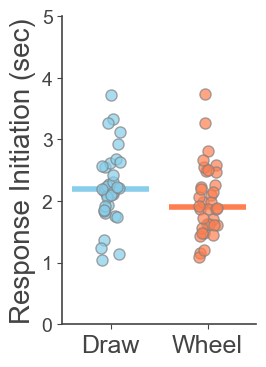

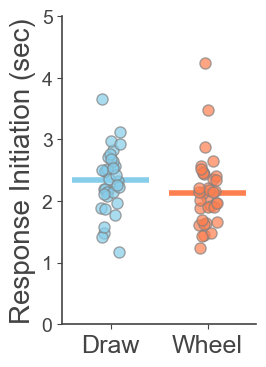

In [142]:
generate_timing_summary_for_all_loads(
    stat_name='start', 
    y_label='Response Initiation (sec)', y_maxs=[5, 5, 5])


##### duration of first attempt

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 2.11±0.19
  Wheel: M ± SEM: 0.61±0.08
  Paired test: t(35)=9.09 (p=0.000) (normality p=0.047)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 1.98 (1.30, 2.89)
  Wheel: Mdn (Q1, Q3): 0.51 (0.19, 0.93)
  Paired test: W=0, n=36 (p=0.000)

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 2.17±0.19
  Wheel: M ± SEM: 0.83±0.12
  Paired test: t(35)=8.34 (p=0.000) (normality p=0.410)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 1.99 (1.42, 3.06)
  Wheel: Mdn (Q1, Q3): 0.73 (0.22, 1.18)
  Paired test: W=7, n=36 (p=0.000)

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 1.89±0.17
  Wheel: M ± SEM: 0.35±0.05
  Paired test: t(35)=9.45 (p=0.000) (normality p=0.094)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 1.71 (1.08, 2.69)
  Wheel: Mdn (Q1, Q3): 0.25 (0.09, 0.56)
  Paired test: W=0, n=36 (p=0.000)



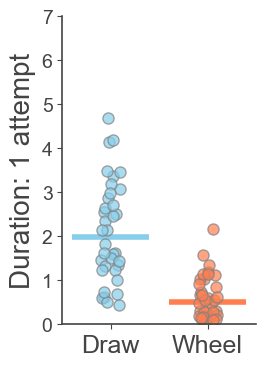

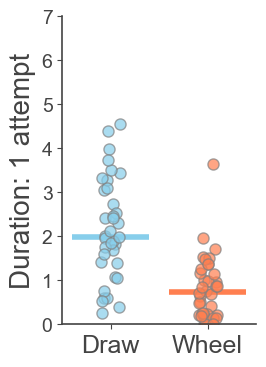

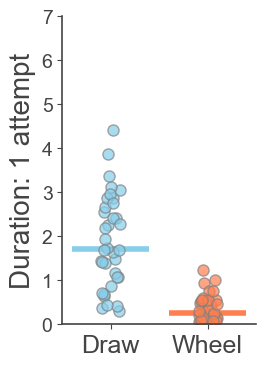

In [143]:
generate_timing_summary_for_all_loads(
    stat_name='first_chunk_duration',
    y_label='Duration: 1 attempt', y_maxs=[7, 7, 7])

##### Full duration

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 7.68±0.39
  Wheel: M ± SEM: 5.40±0.24
  Paired test: t(35)=8.96 (p=0.000) (normality p=0.229)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 7.72 (6.00, 9.55)
  Wheel: Mdn (Q1, Q3): 5.03 (4.55, 6.34)
  Paired test: W=3, n=36 (p=0.000)

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 5.48±0.28
  Wheel: M ± SEM: 4.03±0.18
  Paired test: t(35)=7.56 (p=0.000) (normality p=0.595)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 5.50 (4.23, 6.58)
  Wheel: Mdn (Q1, Q3): 3.89 (3.39, 4.72)
  Paired test: W=24, n=36 (p=0.000)

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 9.56±0.50
  Wheel: M ± SEM: 6.66±0.32
  Paired test: t(35)=8.39 (p=0.000) (normality p=0.283)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 9.31 (7.51, 12.22)
  Wheel: Mdn (Q1, Q3): 6.24 (5.49, 7.95)
  Paired test: W=8, n=36 (p=0.000)



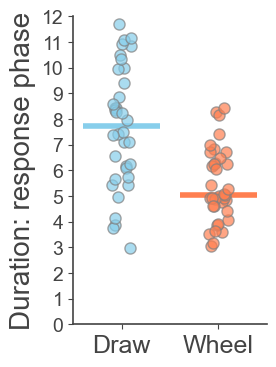

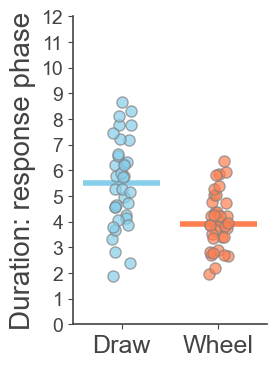

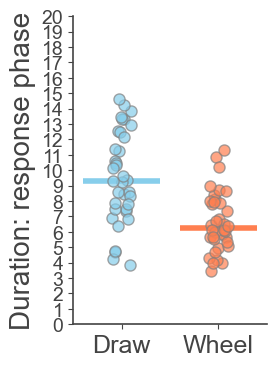

In [144]:
generate_timing_summary_for_all_loads(
    stat_name='phase_duration', 
    y_label='Duration: response phase', y_maxs=[12, 12, 20])

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 4.21±0.31
  Wheel: M ± SEM: 2.01±0.16
  Paired test: t(35)=8.87 (p=0.000) (normality p=0.110)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 4.11 (2.82, 5.49)
  Wheel: Mdn (Q1, Q3): 1.89 (1.14, 2.64)
  Paired test: W=0, n=36 (p=0.000)

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 2.17±0.19
  Wheel: M ± SEM: 0.83±0.12
  Paired test: t(35)=8.34 (p=0.000) (normality p=0.410)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 1.99 (1.42, 3.06)
  Wheel: Mdn (Q1, Q3): 0.73 (0.22, 1.18)
  Paired test: W=7, n=36 (p=0.000)

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 6.02±0.40
  Wheel: M ± SEM: 3.22±0.23
  Paired test: t(35)=8.45 (p=0.000) (normality p=0.187)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 5.26 (4.39, 8.16)
  Wheel: Mdn (Q1, Q3): 2.80 (2.18, 4.19)
  Paired test: W=4, n=36 (p=0.000)



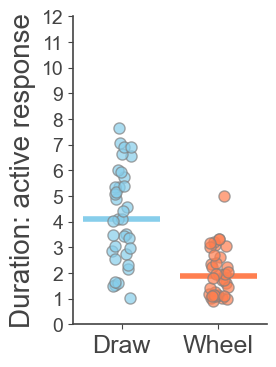

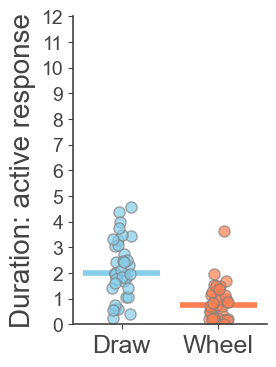

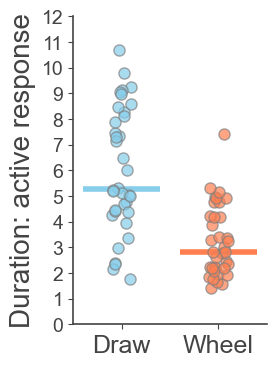

In [145]:
generate_timing_summary_for_all_loads(
    stat_name='active_duration',
    y_label='Duration: active response', y_maxs=[12, 12, 12])

##### Time to confirm

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 1.15±0.04
  Wheel: M ± SEM: 1.25±0.05
  Paired test: t(35)=-2.98 (p=0.005) (normality p=0.526)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 1.15 (0.92, 1.35)
  Wheel: Mdn (Q1, Q3): 1.22 (1.03, 1.51)
  Paired test: W=164, n=36 (p=0.007)

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 1.09±0.04
  Wheel: M ± SEM: 1.19±0.05
  Paired test: t(35)=-2.36 (p=0.024) (normality p=0.150)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 1.06 (0.94, 1.19)
  Wheel: Mdn (Q1, Q3): 1.16 (1.02, 1.29)
  Paired test: W=183, n=36 (p=0.018)

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 1.21±0.06
  Wheel: M ± SEM: 1.29±0.05
  Paired test: t(35)=-1.74 (p=0.091) (normality p=0.000)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 1.18 (0.93, 1.47)
  Wheel: Mdn (Q1, Q3): 1.28 (1.08, 1.53)
  Paired test: W=173, n=36 (p=0.011)



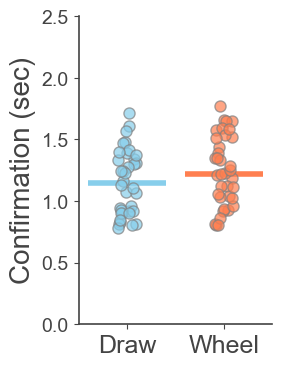

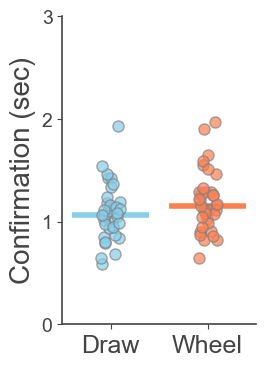

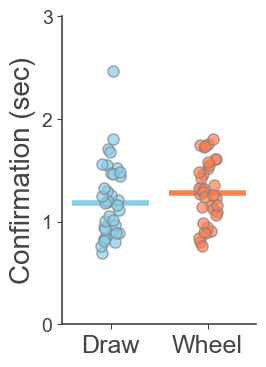

In [146]:
generate_timing_summary_for_all_loads(
    stat_name='confirm', 
    y_label='Confirmation (sec)', y_maxs=[2.5, 3, 3])

#### Figure: add the comparison for different modes

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 0.48±0.08
  Wheel: M ± SEM: 0.73±0.10
  Paired test: t(35)=-2.22 (p=0.033) (normality p=0.394)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 0.37 (0.08, 0.88)
  Wheel: Mdn (Q1, Q3): 0.66 (0.31, 1.10)
  Paired test: W=202, n=36 (p=0.039)



Text(0, 0.5, 'Evidence')

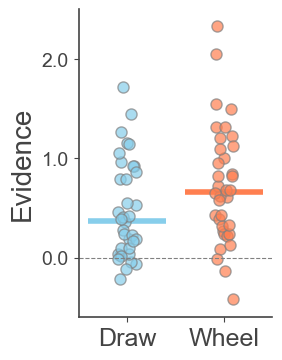

In [147]:
# for gaze data

gaze_metric_cleaned = metric_2x2_df[['gaze_draw', 'gaze_click']].copy()
if TO_CONVERT_NEG:
    gaze_metric_cleaned[gaze_metric_cleaned < 0] = 0.0

ax = plot_paired_data(
    gaze_metric_cleaned, 
    c1='gaze_draw', c2='gaze_click', 
    c1_name='Draw', c2_name='Wheel',
    c1_color=MODE_COLORS['draw'], c2_color=MODE_COLORS['click'],
    mark_center=True,
)

ylim_min = -0.2 if TO_CONVERT_NEG else -0.6
ax.set_ylim([ylim_min, 2.5])
yticks = [0.0, 1.0, 2.0]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=14)
ax.set_ylabel('Evidence', fontsize=20)

Results for Draw vs Wheel (ttest):
  Draw: M ± SEM: 0.38±0.08
  Wheel: M ± SEM: 0.23±0.06
  Paired test: t(35)=3.06 (p=0.004) (normality p=0.008)

Results for Draw vs Wheel (wilcoxon):
  Draw: Mdn (Q1, Q3): 0.20 (0.06, 0.64)
  Wheel: Mdn (Q1, Q3): 0.11 (0.01, 0.38)
  Paired test: W=157, n=36 (p=0.005)



Text(0, 0.5, 'Evidence')

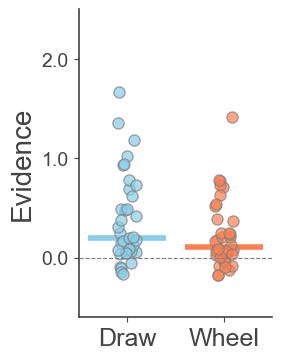

In [148]:
# for hand data

hand_metric_cleaned = metric_2x2_df[['hand_draw', 'hand_click']].copy()
if TO_CONVERT_NEG:
    hand_metric_cleaned[hand_metric_cleaned < 0] = 0.0

ax = plot_paired_data(
    hand_metric_cleaned, 
    c1='hand_draw', c2='hand_click', 
    c1_name='Draw', c2_name='Wheel',
    c1_color=MODE_COLORS['draw'], c2_color=MODE_COLORS['click'],
    mark_center=True,
)

ylim_min = -0.2 if TO_CONVERT_NEG else -0.6
ax.set_ylim([ylim_min, 2.5])
yticks = [0.0, 1.0, 2.0]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=14)
ax.set_ylabel('Evidence', fontsize=20)

### split modes

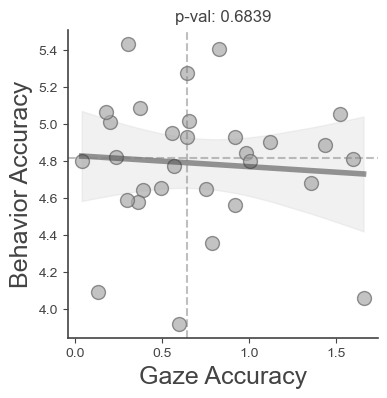

In [77]:
compare_gaze_behav_acc(
    'whole_delay_draw2draw', subj_draw_accs, 
    'reg_draw_behav_gaze_delay_acc')

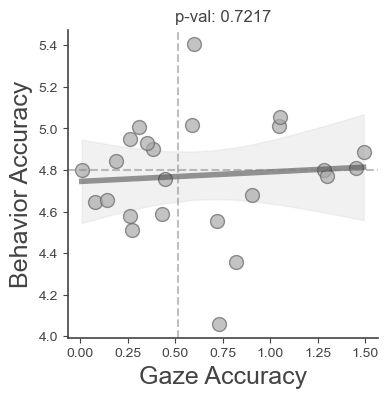

In [78]:
compare_gaze_behav_acc(
    'delay_first_phase_draw2draw', subj_draw_accs, 
    'reg_draw_behav_gaze_delay_start_acc')

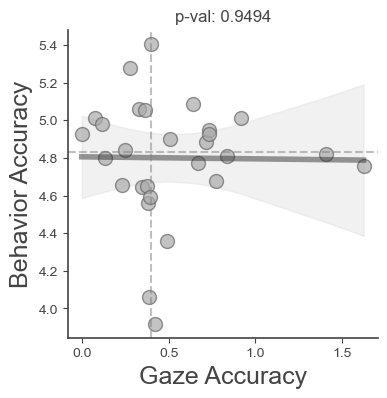

In [79]:
compare_gaze_behav_acc(
    'delay_last_phase_draw2draw', subj_draw_accs, 
    'reg_draw_behav_gaze_delay_end_acc')

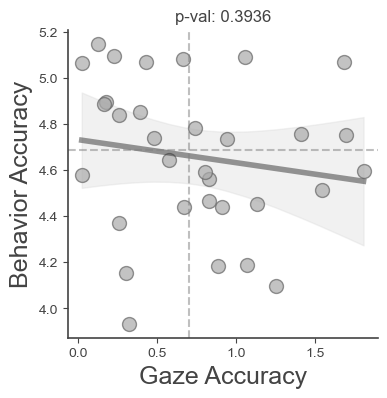

In [80]:
compare_gaze_behav_acc(
    'whole_delay_click2click', subj_click_accs, 
    'reg_click_behav_gaze_delay_acc')

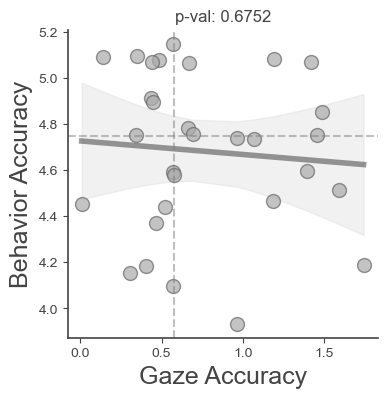

In [81]:
compare_gaze_behav_acc(
    'delay_first_phase_click2click', subj_click_accs, 
    'reg_click_behav_gaze_delay_start_acc')

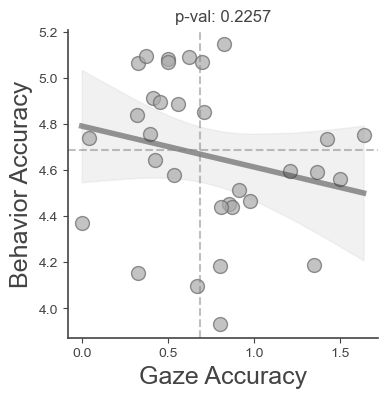

In [82]:
compare_gaze_behav_acc(
    'delay_last_phase_click2click', subj_click_accs, 
    'reg_click_behav_gaze_delay_end_acc')

#### serial bias

In [83]:
def compare_gaze_behav_sd_bias(gaze_stats_name, behav_stats, plot_name, acc_filter=False):
    gaze_bias_path = os.path.join(gaze_stats_path, gaze_stats_name, 'sd.json')
    with open(gaze_bias_path) as f:
        gaze_bias = json.load(f)
    if 'combined' in gaze_bias:
        gaze_bias = gaze_bias['combined']['bias']
    else:
        gaze_bias = gaze_bias['stim 1']['bias']

    # remove those of acc below baseline
    if acc_filter:
        gaze_acc_path = os.path.join(
            gaze_stats_path, gaze_stats_name, 'accuracy.json')
        with open(gaze_acc_path) as f:
            gaze_acc = json.load(f)
        if 'combined' in gaze_acc:
            gaze_acc = gaze_acc['combined']['accuracy']
        else:
            gaze_acc = gaze_acc['stim 1']['accuracy']
        gaze_bias = {k:v for k,v in gaze_bias.items() 
            if gaze_acc[k] > DEFAULT_GAZE_THRESH}
        behav_stats = {k:v for k,v in behav_stats.items()
            if subj_acc_stats[k] > DEFAULT_BEHAV_THRESH}

    # compare gaze and behav
    dispalay_regression_dicts(
        gaze_bias, behav_stats,
        'Gaze Serial Bias', 'Behavior Serial Bias',
        plot_name)

In [84]:
subj_sd_stats = compute_subj_behav_stats(default_lmb, 'sd')
subj_draw_sds = compute_subj_behav_stats(draw_lmb, 'sd')
subj_click_sds = compute_subj_behav_stats(click_lmb, 'sd')

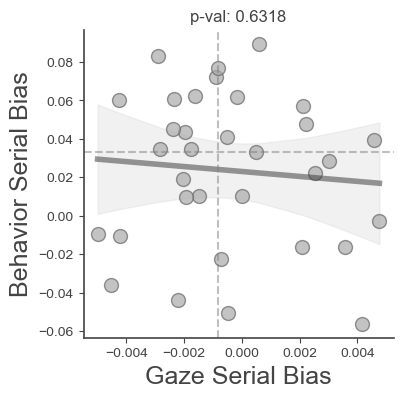

In [85]:
compare_gaze_behav_sd_bias(
    'whole_delay_combined', subj_sd_stats, 
    'reg_behav_gaze_delay_sd',
    acc_filter=True)

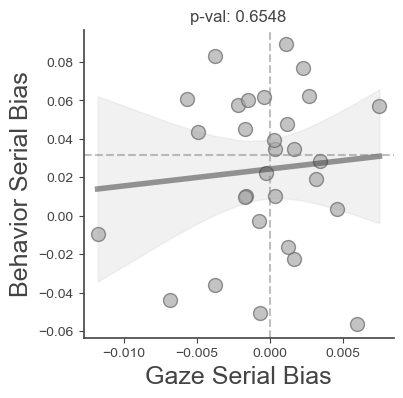

In [86]:
compare_gaze_behav_sd_bias(
    'whole_delay_draw2draw', subj_sd_stats, 
    'reg_behav_gaze_draw_delay_sd',
    acc_filter=True)

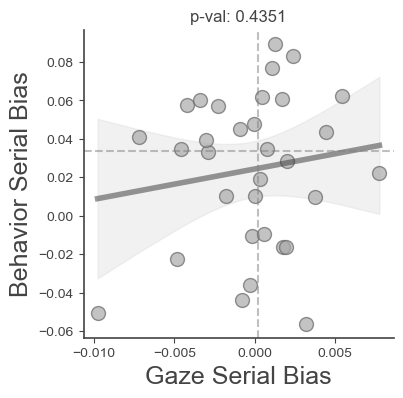

In [87]:
compare_gaze_behav_sd_bias(
    'whole_delay_click2click', subj_sd_stats, 
    'reg_behav_gaze_click_delay_sd',
    acc_filter=True)

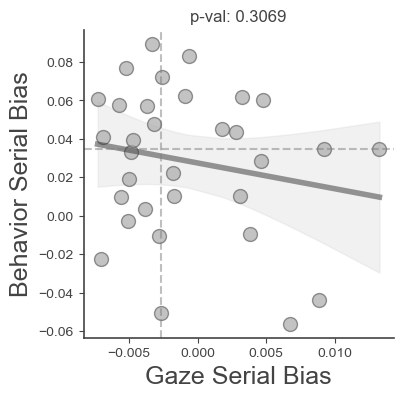

In [88]:
compare_gaze_behav_sd_bias(
    'delay_last_phase_combined', subj_sd_stats, 
    'reg_behav_gaze_delay_end_sd',
    acc_filter=True)

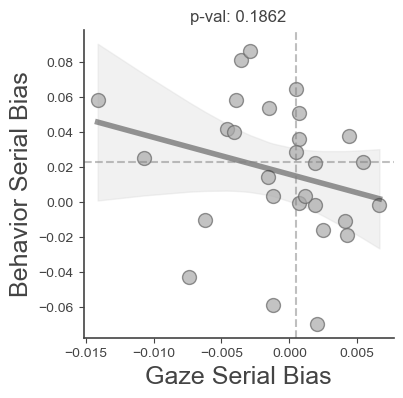

In [89]:
compare_gaze_behav_sd_bias(
    'delay_last_phase_draw2draw', subj_draw_sds, 
    'reg_draw_behav_gaze_delay_end_sd',
    acc_filter=True)

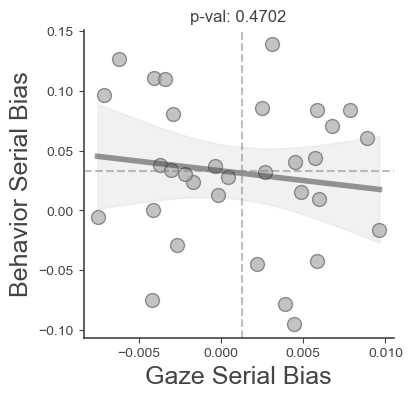

In [90]:
compare_gaze_behav_sd_bias(
    'delay_last_phase_click2click', subj_click_sds, 
    'reg_click_behav_gaze_delay_end_sd',
    acc_filter=True)

**comments**: unfortunately...

##### Try taking the average over the end of delay...

In [91]:
TRIAL_TIMEPOINT_PRED_PATH = os.path.join(gaze_stats_path, 'predictions')

In [92]:
last_phase_ids = [8, 9, 10]
def load_avg_preds(mode, phase_ids, lmb, align_type):
    mode_path = os.path.join(TRIAL_TIMEPOINT_PRED_PATH, f'{mode}_delay_phase')
    df = pd.read_csv(os.path.join(mode_path, 'y_df.csv'), index_col=0)
    select_mask = lmb(df) if lmb is not None else np.ones(df.shape[0], dtype=bool)
    stim_masks = {
        'stim_1': select_mask.copy(),
        'stim_2': select_mask.copy(),
    }
    preds = [[], []]
    for pid in phase_ids:
        for i, stim_id in enumerate(['stim_1', 'stim_2']):
            loaded = np.load(
                os.path.join(mode_path, f'phase_{pid}', 
                    'aligned', stim_id, f'{align_type}.npy'), 
                allow_pickle=True)
            load_valid_mask = (~(np.isnan(loaded[:, 0]))) & stim_masks[stim_id]
            stim_masks[stim_id] = stim_masks[stim_id] & load_valid_mask
            # print(np.sum(select_mask))
            preds[i].append(loaded[load_valid_mask])
    preds = [np.mean(ps, axis=0) for ps in preds]
    dfs = [df[stim_masks[stim_id]] for stim_id in ['stim_1', 'stim_2']]
    return dfs, preds

In [93]:
draw_last_phase_target_avg = load_avg_preds('draw', last_phase_ids, None, 'target')
click_last_phase_target_avg = load_avg_preds('click', last_phase_ids, None, 'target')

In [94]:
draw_last_phase_prev_avg = load_avg_preds('draw', last_phase_ids, None, 'previous')
click_last_phase_prev_avg = load_avg_preds('click', last_phase_ids, None, 'previous')

In [95]:
def last_phase_avg_to_stats(df, avg_preds, stat_type, acc_thresh=DEFAULT_GAZE_THRESH):
    # we don't care stim 1 or 2 just collapse them
    df = pd.concat((df[0], df[1]), axis=0, ignore_index=True)
    avg_preds = np.concatenate((avg_preds[0], avg_preds[1]), axis=0)

    subjects = df['participant'].to_numpy()
    all_subj_stats = {}
    for subj in all_subjs:
        subj_mask = subjects == int(subj)
        if np.sum(subj_mask) == 0:
            # subject do not have enough data...
            continue
        subj_preds = avg_preds[subj_mask]
        subj_distrib = np.mean(subj_preds, axis=0)
        subj_distrib = subj_distrib / np.sum(subj_distrib)
        stat_func = compute_accuracy if stat_type == 'accuracy' else compute_bias
        stat = stat_func(subj_distrib, T=180)
        all_subj_stats[subj] = stat

    if acc_thresh is not None:
        # remove those of acc below baseline
        all_subj_stats = {k: v for k, v in all_subj_stats.items() 
            if subj_acc_stats[k] > acc_thresh}

    return all_subj_stats

In [96]:
gaze_draw_last_phase_avg_acc = last_phase_avg_to_stats(
    draw_last_phase_target_avg[0], 
    draw_last_phase_target_avg[1],
    'accuracy'
)

<Axes: title={'center': 'p-val: 0.1235'}, xlabel='Gaze Accuracy', ylabel='Behavior Accuracy'>

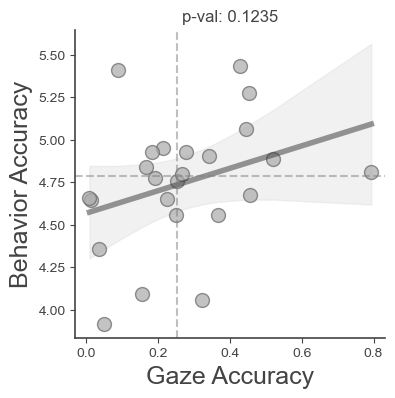

In [97]:
gacc = {k:v for k, v in gaze_draw_last_phase_avg_acc.items() if v > DEFAULT_GAZE_THRESH}
bacc = {k:v for k, v in subj_draw_accs.items() if v > DEFAULT_BEHAV_THRESH}
dispalay_regression_dicts(
    gacc, bacc,
    'Gaze Accuracy', 'Behavior Accuracy',
    'reg_draw_last_phase_avg_acc')

In [98]:
gaze_draw_last_phase_avg_sd = last_phase_avg_to_stats(
    draw_last_phase_prev_avg[0], 
    draw_last_phase_prev_avg[1],
    'bias'
)

In [99]:
gaze_click_last_phase_avg_sd = last_phase_avg_to_stats(
    click_last_phase_prev_avg[0], 
    click_last_phase_prev_avg[1],
    'bias'
)

<Axes: title={'center': 'p-val: 0.3988'}, xlabel='Gaze Serial Bias', ylabel='Behavior Serial Bias'>

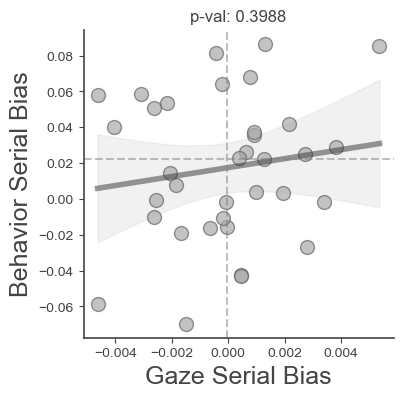

In [100]:
gsd = gaze_draw_last_phase_avg_sd
bacc = {k:v for k, v in subj_draw_accs.items() if v > DEFAULT_BEHAV_THRESH}
bsd = {k:subj_draw_sds[k] for k in bacc}
dispalay_regression_dicts(
    gsd, bsd,
    'Gaze Serial Bias', 'Behavior Serial Bias',
    'reg_draw_last_phase_avg_sd')

<Axes: title={'center': 'p-val: 0.9495'}, xlabel='Gaze Serial Bias', ylabel='Behavior Serial Bias'>

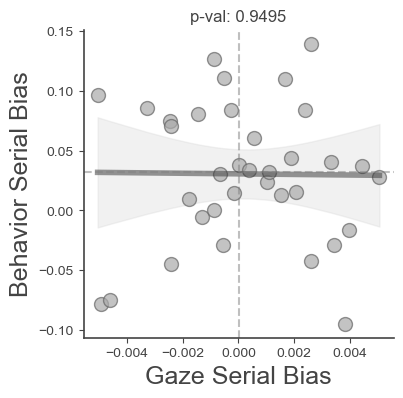

In [101]:
gsd = gaze_click_last_phase_avg_sd
bacc = {k:v for k, v in subj_click_accs.items() if v > DEFAULT_BEHAV_THRESH}
bsd = {k:subj_click_sds[k] for k in bacc}
dispalay_regression_dicts(
    gsd, bsd,
    'Gaze Serial Bias', 'Behavior Serial Bias',
    'reg_click_last_phase_avg_sd')

##### check if there are some interaction between acc and sd...

<Axes: title={'center': 'p-val: 0.1848'}, xlabel='Gaze Serial Bias', ylabel='Behavior accuracy'>

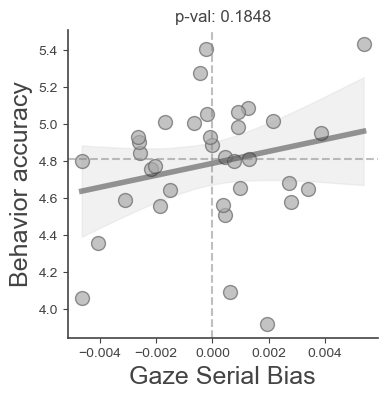

In [102]:
bacc = {k:v for k, v in subj_draw_accs.items() if v > DEFAULT_BEHAV_THRESH}
dispalay_regression_dicts(
    gaze_draw_last_phase_avg_sd, 
    bacc,
    'Gaze Serial Bias', 
    'Behavior accuracy', 
    'reg_behav_acc_draw_gaze_sd')

# one subject kicked out for bad performance (outlier, below 3.5)

<Axes: title={'center': 'p-val: 0.1206'}, xlabel='Gaze Serial Bias', ylabel='Behavior accuracy'>

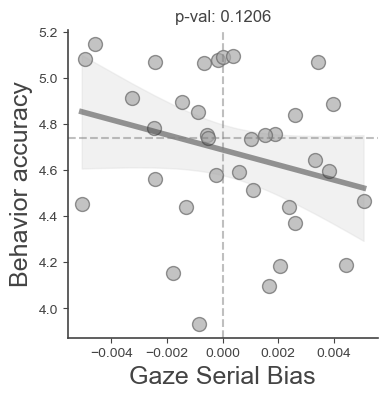

In [103]:
bacc = {k:v for k, v in subj_click_accs.items() if v > DEFAULT_BEHAV_THRESH}
dispalay_regression_dicts(
    gaze_click_last_phase_avg_sd, 
    bacc,
    'Gaze Serial Bias', 
    'Behavior accuracy', 
    'reg_behav_acc_click_gaze_sd')

##### lastly, does accuracy has anything to do with SD in behavior?

[Text(4.0, 0, '4.0'),
 Text(4.5, 0, '4.5'),
 Text(5.0, 0, '5.0'),
 Text(5.5, 0, '5.5')]

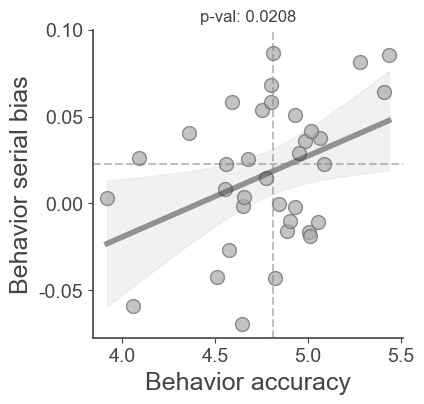

In [104]:
bacc = {k:v for k, v in subj_draw_accs.items() if v > DEFAULT_BEHAV_THRESH}
ax = dispalay_regression_dicts(
    bacc, 
    subj_draw_sds,
    'Behavior accuracy', 
    'Behavior serial bias', 
    'reg_draw_behav_acc_sd')

yticks = [-0.05, 0.0, 0.05, 0.10]
ax.set_yticks(yticks)
ax.set_yticklabels([f'{y:.2f}' for y in yticks], fontsize=14)
xticks = [4.0, 4.5, 5.0, 5.5]
ax.set_xticks(xticks)
ax.set_xticklabels([f'{x:.1f}' for x in xticks], fontsize=14)

[Text(4.0, 0, '4.0'),
 Text(4.5, 0, '4.5'),
 Text(5.0, 0, '5.0'),
 Text(5.5, 0, '5.5')]

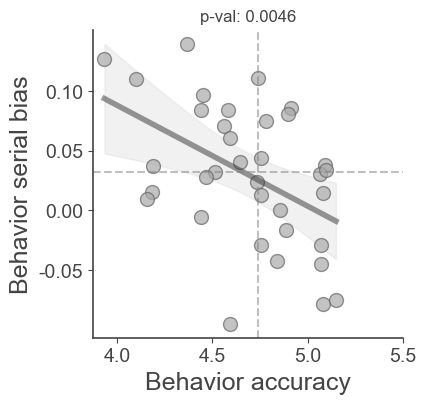

In [105]:
bacc = {k:v for k, v in subj_click_accs.items() if v > DEFAULT_BEHAV_THRESH}
ax = dispalay_regression_dicts(
    bacc, 
    subj_click_sds,
    'Behavior accuracy', 
    'Behavior serial bias', 
    'reg_click_behav_acc_sd')

yticks = [-0.05, 0.0, 0.05, 0.10]
ax.set_yticks(yticks)
ax.set_yticklabels([f'{y:.2f}' for y in yticks], fontsize=14)
xticks = [4.0, 4.5, 5.0, 5.5]
ax.set_xticks(xticks)
ax.set_xticklabels([f'{x:.1f}' for x in xticks], fontsize=14)

#### Not really behavior analysis but we make use of the code here...

In [106]:
bacc = {k:v for k, v in subj_acc_stats.items() if v > DEFAULT_BEHAV_THRESH}

In [107]:
def confine_ratio_compare(ax, smin=-0.2, smax=2.5):
    ax.set_ylim([smin, smax])
    ax.set_xlim([smin, smax])
    ticks = np.linspace(0, np.floor(smax), 3)
    np.sort(ticks)
    tick_size = 18
    ticks = np.round(ticks).astype(int)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, fontsize=tick_size)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks, fontsize=tick_size)

    # mark 0
    ax.axvline(0, color='gray', alpha=0.5, linestyle='--')
    ax.axhline(0, color='gray', alpha=0.5, linestyle='--')


In [108]:
acc_plot_cutoff = None # 0.0

Estimate: [0.35309479 0.56008023]
Confidence intervals: [[0.22410835 0.48208124]
 [0.38078156 0.7393789 ]]


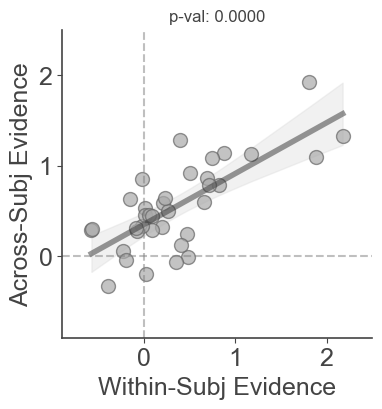

In [109]:
acc_within_subj_enc = load_acc_stats('within_subj_enc1_after_cue_combined')
acc_across_subj_enc = load_acc_stats('enc1_after_cue_combined')

ax = dispalay_regression_dicts(
    acc_within_subj_enc, 
    acc_across_subj_enc,
    'Within-Subj Evidence', 
    'Across-Subj Evidence', 
    'reg_enc_within_vs_across_subj',
    show_conf_int=True,
    mark_median=False,
    l1_cutoff=acc_plot_cutoff, 
    l2_cutoff=acc_plot_cutoff)
confine_ratio_compare(ax, smin=-0.9)


Estimate: [0.22555831 0.64976813]
Confidence intervals: [[0.09917024 0.35194637]
 [0.48998045 0.80955582]]


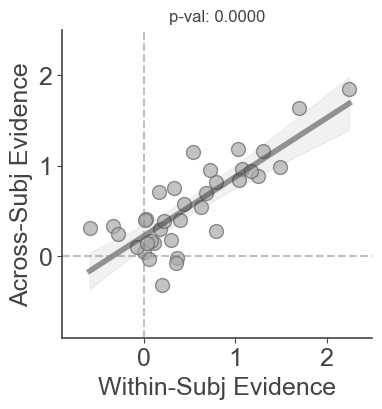

In [110]:
acc_within_subj_enc = load_acc_stats('within_subj_isi_combined')
acc_across_subj_enc = load_acc_stats('whole_isi_combined')

ax = dispalay_regression_dicts(
    acc_within_subj_enc, 
    acc_across_subj_enc,
    'Within-Subj Evidence', 
    'Across-Subj Evidence', 
    'reg_isi_within_vs_across_subj',
    show_conf_int=True,
    mark_median=False,
    l1_cutoff=acc_plot_cutoff, 
    l2_cutoff=acc_plot_cutoff)
confine_ratio_compare(ax, smin=-0.9)

Estimate: [0.40067769 0.36198729]
Confidence intervals: [[0.23748732 0.56386806]
 [0.17362138 0.55035321]]


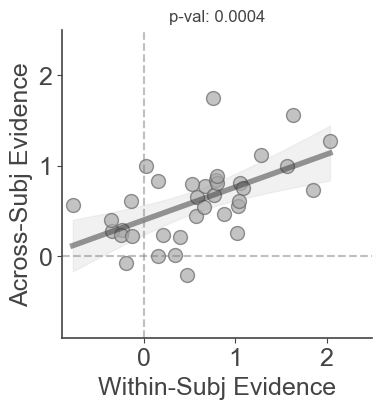

In [111]:
acc_within_subj_enc = load_acc_stats('within_subj_delay_combined')
acc_across_subj_enc = load_acc_stats('whole_delay_combined')

ax = dispalay_regression_dicts(
    acc_within_subj_enc, 
    acc_across_subj_enc,
    'Within-Subj Evidence', 
    'Across-Subj Evidence',
    'reg_delay_within_vs_across_subj',
    show_conf_int=True,
    mark_median=False,
    l1_cutoff=acc_plot_cutoff, 
    l2_cutoff=acc_plot_cutoff)
confine_ratio_compare(ax, smin=-0.9)

#### Do the same thing for hand data

Estimate: [1.17960341 0.88825265]
Confidence intervals: [[0.68185158 1.67735524]
 [0.67062511 1.1058802 ]]


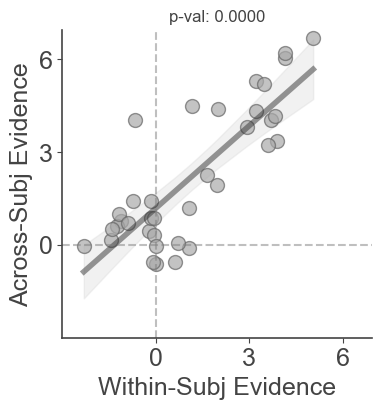

In [112]:
hand_acc_within_subj_isi = load_hand_stats('stim 1', 'within_subj_isi_combined')
hand_acc_across_subj_isi = load_hand_stats('stim 1', 'isi_combined')

ax = dispalay_regression_dicts(
    hand_acc_within_subj_isi, 
    hand_acc_across_subj_isi,
    'Within-Subj Evidence', 
    'Across-Subj Evidence', 
    'reg_hand_isi_within_vs_across_subj',
    show_conf_int=True,
    mark_median=False,
    l1_cutoff=acc_plot_cutoff, 
    l2_cutoff=acc_plot_cutoff)

confine_ratio_compare(ax, smin=-3, smax=6.95)

Estimate: [0.09501175 0.54988196]
Confidence intervals: [[-0.02084615  0.21086966]
 [ 0.35900512  0.74075881]]


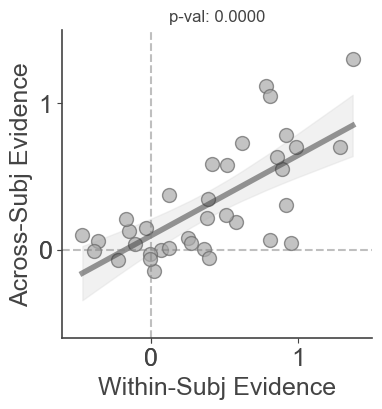

In [113]:
hand_acc_within_subj_delay = load_hand_stats('combined', 'within_subj_delay_combined')
hand_acc_across_subj_delay = load_hand_stats('combined', 'whole_delay_combined')

ax = dispalay_regression_dicts(
    hand_acc_within_subj_delay, 
    hand_acc_across_subj_delay,
    'Within-Subj Evidence', 
    'Across-Subj Evidence', 
    'reg_hand_delay_within_vs_across_subj',
    show_conf_int=True,
    mark_median=False,
    l1_cutoff=acc_plot_cutoff, 
    l2_cutoff=acc_plot_cutoff)

confine_ratio_compare(ax, smin=-0.6, smax=1.5)

##### Does across phase decoding quality has anything to do with behavior?

##### firstly, does the cross phase accuracy has any correlation?

In [114]:
acc_enc = load_acc_stats('enc1_after_cue_combined')
acc_enc_isi = load_acc_stats('enc1_isi_combined')
acc_enc_delay = load_acc_stats('enc1_delay_combined')
acc_isi = load_acc_stats('whole_isi_combined')
acc_isi_delay = load_acc_stats('isi_delay_combined')
acc_delay = load_acc_stats('whole_delay_combined')

<Axes: title={'center': 'p-val: 0.0002'}, xlabel='Enc -> Enc Accuracy', ylabel='Enc -> ISI Accuracy'>

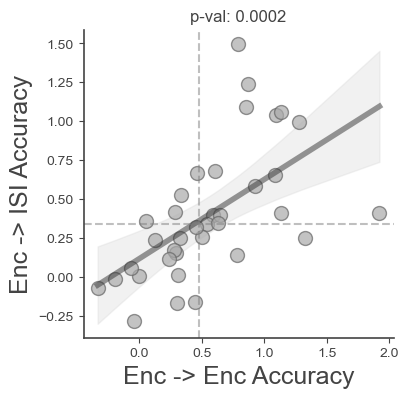

In [115]:
dispalay_regression_dicts(
    acc_enc, 
    acc_enc_isi,
    'Enc -> Enc Accuracy', 
    'Enc -> ISI Accuracy', 
    'reg_enc_vs_enc_isi')

<Axes: title={'center': 'p-val: 0.0000'}, xlabel='ISI -> ISI Accuracy', ylabel='Enc -> ISI Accuracy'>

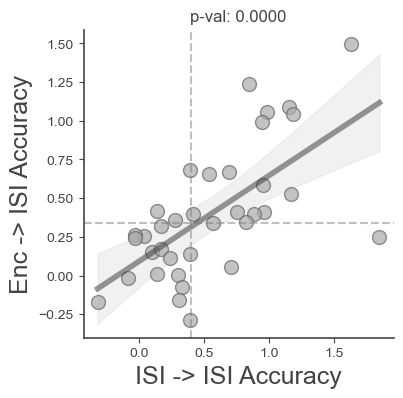

In [116]:
dispalay_regression_dicts(
    acc_isi, 
    acc_enc_isi,
    'ISI -> ISI Accuracy', 
    'Enc -> ISI Accuracy', 
    'reg_isi_vs_enc_isi')

<Axes: title={'center': 'p-val: 0.0000'}, xlabel='ISI -> ISI Accuracy', ylabel='ISI -> Delay Accuracy'>

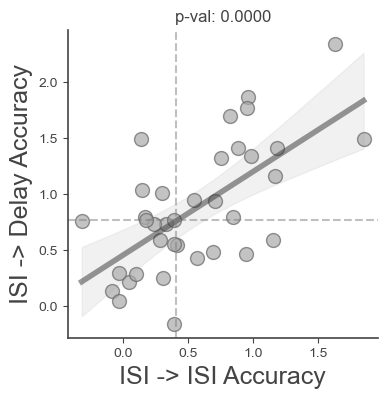

In [117]:
dispalay_regression_dicts(
    acc_isi, 
    acc_isi_delay,
    'ISI -> ISI Accuracy', 
    'ISI -> Delay Accuracy',
    'reg_isi_vs_isi_delay')

<Axes: title={'center': 'p-val: 0.0000'}, xlabel='Delay -> Delay Accuracy', ylabel='ISI -> Delay Accuracy'>

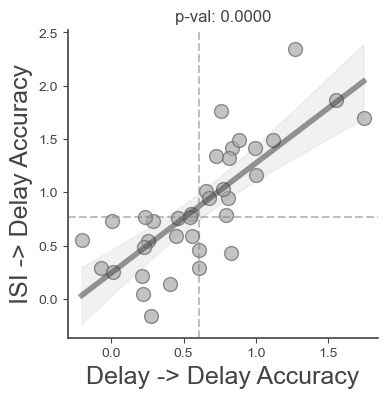

In [118]:
dispalay_regression_dicts(
    acc_delay, 
    acc_isi_delay,
    'Delay -> Delay Accuracy', 
    'ISI -> Delay Accuracy',
    'reg_delay_vs_isi_delay')

<Axes: title={'center': 'p-val: 0.0001'}, xlabel='Enc -> Enc Accuracy', ylabel='ISI -> ISI Accuracy'>

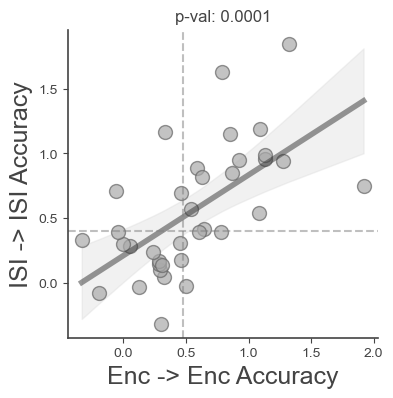

In [119]:
dispalay_regression_dicts(
    acc_enc,
    acc_isi,
    'Enc -> Enc Accuracy',
    'ISI -> ISI Accuracy',
    'reg_enc_vs_isi')

<Axes: title={'center': 'p-val: 0.0003'}, xlabel='ISI -> ISI Accuracy', ylabel='Delay -> Delay Accuracy'>

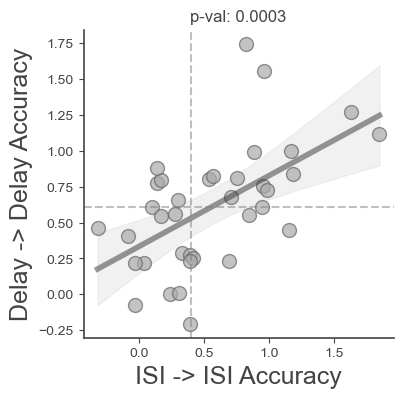

In [120]:
dispalay_regression_dicts(
    acc_isi,
    acc_delay,
    'ISI -> ISI Accuracy',
    'Delay -> Delay Accuracy', 
    'reg_isi_vs_delay')

##### Secondly, do any of these newly added acc has anything to do with behavior performance?

<Axes: title={'center': 'p-val: 0.0510'}, xlabel='Enc -> Enc Accuracy', ylabel='Behavior Accuracy'>

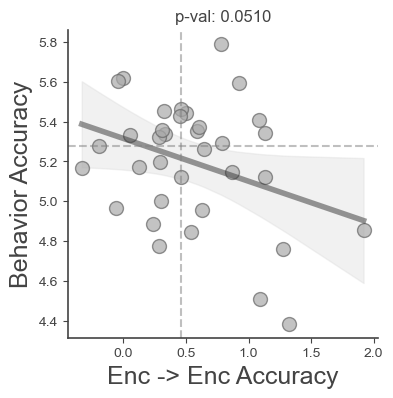

In [121]:
dispalay_regression_dicts(
    acc_enc, 
    bacc,
    'Enc -> Enc Accuracy', 
    'Behavior Accuracy', 
    'reg_enc_vs_behav')

<Axes: title={'center': 'p-val: 0.3132'}, xlabel='Enc -> ISI Accuracy', ylabel='Behavior Accuracy'>

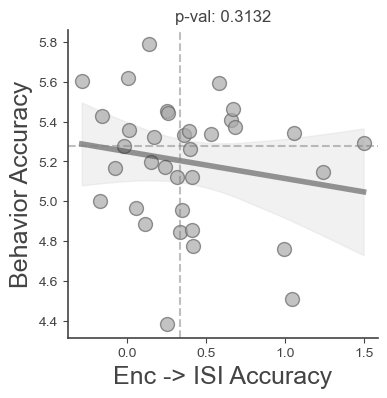

In [122]:
dispalay_regression_dicts(
    acc_enc_isi, 
    bacc,
    'Enc -> ISI Accuracy', 
    'Behavior Accuracy', 
    'reg_enc_isi_vs_behav')

<Axes: title={'center': 'p-val: 0.0499'}, xlabel='ISI -> ISI Accuracy', ylabel='Behavior Accuracy'>

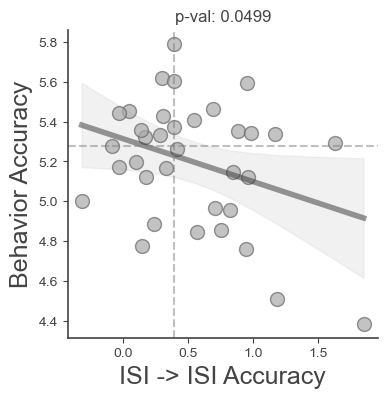

In [123]:
dispalay_regression_dicts(
    acc_isi, 
    bacc,
    'ISI -> ISI Accuracy', 
    'Behavior Accuracy', 
    'reg_isi_vs_behav')

<Axes: title={'center': 'p-val: 0.1864'}, xlabel='ISI -> Delay Accuracy', ylabel='Behavior Accuracy'>

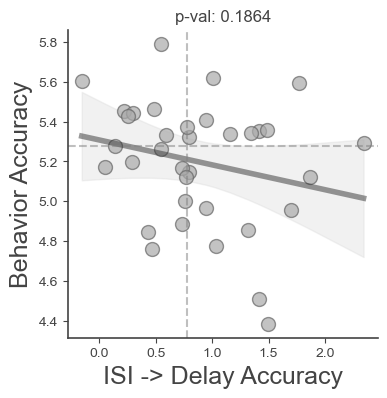

In [124]:
dispalay_regression_dicts(
    acc_isi_delay, 
    bacc,
    'ISI -> Delay Accuracy', 
    'Behavior Accuracy', 
    'reg_isi_delay_vs_behav')

<Axes: title={'center': 'p-val: 0.5235'}, xlabel='Enc -> Delay Accuracy', ylabel='Behavior Accuracy'>

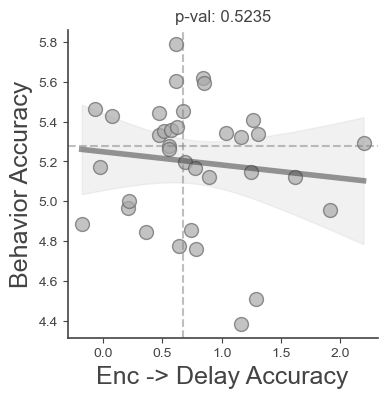

In [125]:
dispalay_regression_dicts(
    acc_enc_delay, 
    bacc,
    'Enc -> Delay Accuracy', 
    'Behavior Accuracy', 
    'reg_enc_delay_vs_behav')

**Comments** 

- Again None of them show any significant relationship with behavioral performance....
- But their are correlations between eye decodability at different phases.

## What about hand motions?

In [126]:
hand_stats_path = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'stats',
    'mouse', 'inverted_enc')

with open(os.path.join(hand_stats_path, 'draw', 'accuracy.json')) as f:
    hand_draw_acc = json.load(f)
    hand_draw_acc = hand_draw_acc['combined']['accuracy']

with open(os.path.join(hand_stats_path, 'click', 'accuracy.json')) as f:
    hand_click_acc = json.load(f)
    hand_click_acc = hand_click_acc['combined']['accuracy']


In [127]:
gaze_draw_acc = load_acc_stats('whole_delay_draw2draw')
gaze_click_acc = load_acc_stats('whole_delay_click2click')

<Axes: title={'center': 'p-val: 0.1524'}, xlabel='Gaze Acc', ylabel='Hand Acc'>

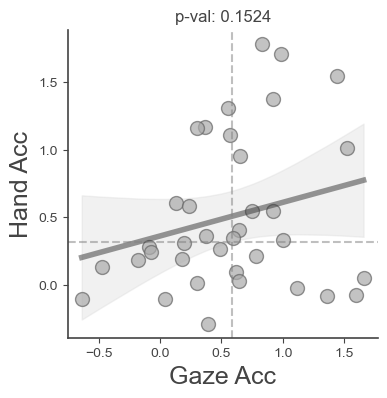

In [128]:
dispalay_regression_dicts(
    gaze_draw_acc, 
    hand_draw_acc,
    'Gaze Acc',
    'Hand Acc', 
    'reg_gaze_vs_hand_draw_acc')

<Axes: title={'center': 'p-val: 0.7789'}, xlabel='Gaze Acc', ylabel='Hand Acc'>

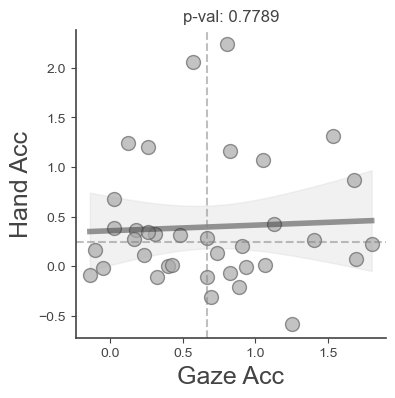

In [129]:
dispalay_regression_dicts(
    gaze_click_acc, 
    hand_click_acc,
    'Gaze Acc',
    'Hand Acc', 
    'reg_gaze_vs_hand_click_acc')

## Pull out survey questions

In [114]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [115]:
from utils.survey import preprocess_survey

survey_path = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'survey', 'survey_25Apr.csv')
survey_df = pd.read_csv(survey_path)
survey_df = preprocess_survey(survey_df)
survey_df['subject'] = survey_df.index.astype(str)
survey_df.reset_index(drop=True, inplace=True)

In [116]:
# keep only those in target subject list
target_survey = survey_df[survey_df['subject'].isin(all_subjs)]

### first check the strategy question

In [117]:
def plot_one_question(ax, df, qname, label_map, xmax=12):
    # label map: mapping numeric label to text
    labels, counts = np.unique(df[qname], return_counts=True)
    counts = {k:v for k,v in zip(labels, counts)}
    labels_sorted = [label for label in label_map.keys()] # if label in labels
    counts_sorted = [
        counts.get(label, 0) for label in labels_sorted]
    captions = [label_map[label] for label in labels_sorted]
    ax.barh(captions, counts_sorted, color='skyblue')
    for i, count in enumerate(counts_sorted):
        ax.text(count+0.8*xmax/10, i, str(count), va='center', ha='right')
    ax.set_yticks(np.arange(len(captions)))
    ax.set_yticklabels(captions)
    ax.invert_yaxis()
    if xmax is not None:
        ax.set_xlim([0, xmax])
    ax.set_xticks([])

In [118]:
from collections import OrderedDict

def plot_strategy_questions(survey_data, xmax=20):
    questions = OrderedDict([
        ('Q1.2', 'draw, null cue'),
        ('Q1.3', 'draw, informatic cue'),
        ('Q1.4', 'click, null cue'),
        ('Q1.5', 'click, informatic cue'),
    ])

    fig, axs = plt.subplots(1, len(questions), figsize=(4*len(questions), 3))
    for plot_id, qname in enumerate(list(questions.keys())):
        label_map = OrderedDict([
            (1, 'pictorial'), 
            (2, 'abstract'), 
            (3, 'action'), 
            # (4, 'mixed'), 
            # (5, 'other'),
        ])
        plot_one_question(axs[plot_id], survey_data, qname, label_map, xmax=xmax)
        axs[plot_id].set_title(questions[qname])
    plt.tight_layout()

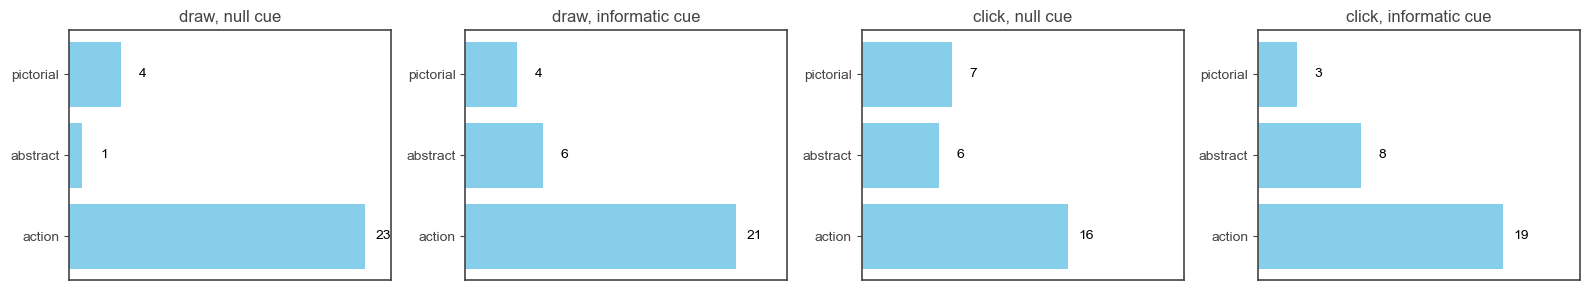

In [119]:
plot_strategy_questions(target_survey, xmax=25)
plot_path = os.path.join(
    PLOTS_FOLDER, 'strategy_questions.png')
plt.savefig(plot_path, bbox_inches='tight')

#### do strategies preference affect the accuracy?

In [120]:
strategy_dicts = target_survey[['Q1.2', 'Q1.3', 'Q1.4', 'Q1.5', 'subject']].to_dict(orient='records')

In [121]:
def collect_multi_question_scores(dicts, qs, score_func):
    scores = {}
    for rec in dicts:
        s = [score_func(rec[q]) for q in qs]
        s = [s1 for s1 in s if s1 is not None]
        if len(s) == 0:
            continue
        s = np.mean(s)
        scores[rec['subject']] = s
    return scores

In [122]:
stat_q_score_func = lambda x: (x if x <=3 else None)
draw_action_survey_scores = collect_multi_question_scores(
    strategy_dicts, ['Q1.2', 'Q1.3'], stat_q_score_func)

In [123]:
click_action_survey_scores = collect_multi_question_scores(
    strategy_dicts, ['Q1.4', 'Q1.5'], stat_q_score_func)

In [124]:
all_action_survey_scores = collect_multi_question_scores(
    strategy_dicts, ['Q1.2', 'Q1.3', 'Q1.4', 'Q1.5'], stat_q_score_func)

<Axes: title={'center': 'p-val: 0.3403'}, xlabel='Survey: action-prepared', ylabel='Behavior Accuracy'>

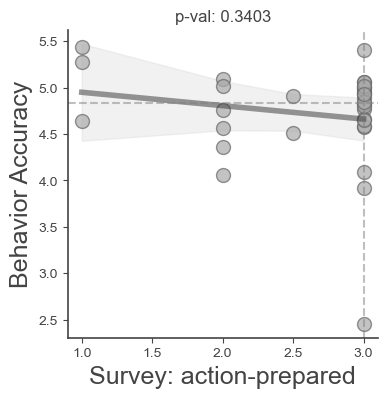

In [125]:
dispalay_regression_dicts(
    draw_action_survey_scores,
    subj_draw_accs,
    'Survey: action-prepared', 
    'Behavior Accuracy', 
    'reg_draw_q1_vs_behav')

<Axes: title={'center': 'p-val: 0.1770'}, xlabel='Survey: action-prepared', ylabel='Decoding Accuracy'>

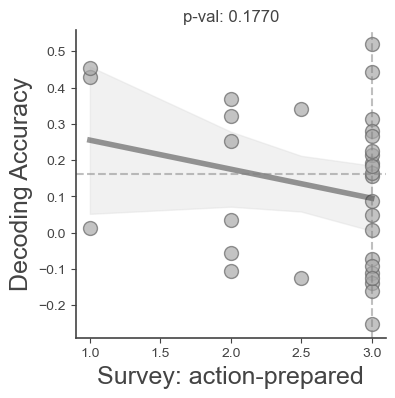

In [126]:
dispalay_regression_dicts(
    draw_action_survey_scores,
    gaze_draw_last_phase_avg_acc,
    'Survey: action-prepared', 
    'Decoding Accuracy', 
    'reg_draw_q1_vs_gaze_acc')

<Axes: title={'center': 'p-val: 0.9103'}, xlabel='Survey: action-prepared', ylabel='Behavior Accuracy'>

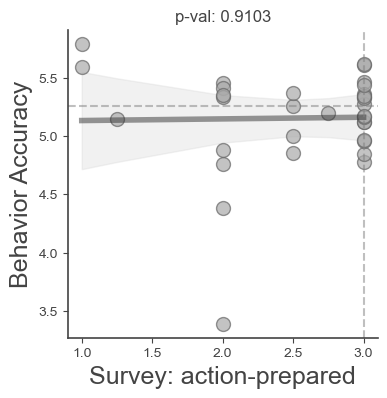

In [127]:
dispalay_regression_dicts(
    all_action_survey_scores,
    subj_acc_stats,
    'Survey: action-prepared', 
    'Behavior Accuracy', 
    'reg_q1_vs_behav')

<Axes: title={'center': 'p-val: 0.2468'}, xlabel='Survey: action-prepared', ylabel='Decoding Accuracy'>

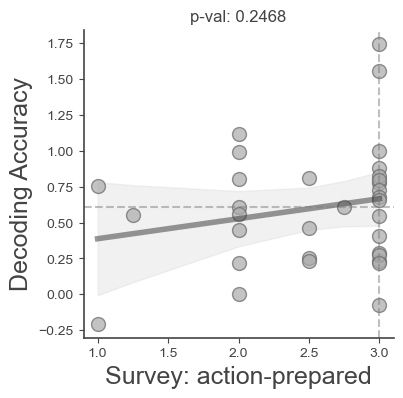

In [128]:
dispalay_regression_dicts(
    all_action_survey_scores,
    acc_delay,
    'Survey: action-prepared', 
    'Decoding Accuracy', 
    'reg_q1_vs_gaze_acc_delay')

<Axes: title={'center': 'p-val: 0.0378'}, xlabel='Survey: action-prepared', ylabel='Decoding Accuracy'>

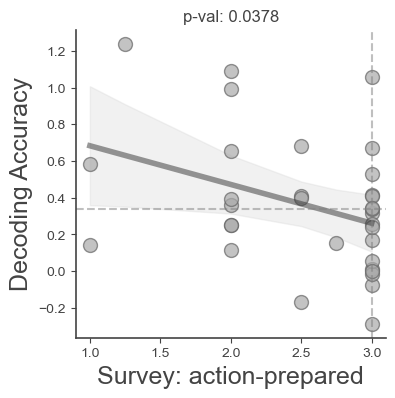

In [129]:
dispalay_regression_dicts(
    all_action_survey_scores,
    acc_enc_isi,
    'Survey: action-prepared', 
    'Decoding Accuracy', 
    'reg_q1_vs_gaze_acc_enc_isi')

**comment**: hehe

### Next we extract their answers to imagery question

In [130]:
def collect_imagery_question_scores(dicts, q, n_choices):
    scores = {}
    w = (n_choices + 1) / 2
    for rec in dicts:
        s = rec[q]
        s = (s - w) / w
        s = -s # originall smaller means more imagery
        scores[rec['subject']] = s
    return scores

In [131]:
imagery_dicts = target_survey[['Q6', 'Q7', 'subject']].to_dict(orient='records')

In [132]:
imagery_6_scores = collect_imagery_question_scores(imagery_dicts, 'Q6', 5)
imagery_7_scores = collect_imagery_question_scores(imagery_dicts, 'Q7', 3)

In [133]:
imagery_scores = {s: (imagery_6_scores[s] + imagery_7_scores[s])/2 for s in all_subjs}

#### Any correlation between questions?

<Axes: title={'center': 'p-val: 0.4461'}, xlabel='Imagery 6 scores', ylabel='Imagery 7 scores'>

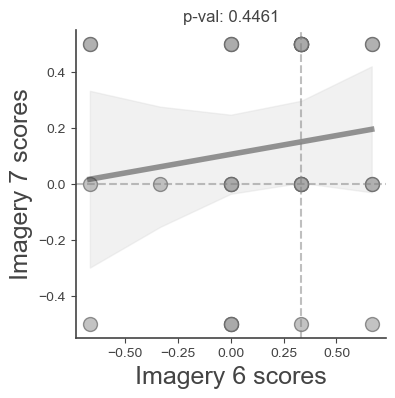

In [134]:
dispalay_regression_dicts(
    imagery_6_scores,
    imagery_7_scores,
    'Imagery 6 scores',
    'Imagery 7 scores', 
    'reg_q6_vs_q7')

<Axes: title={'center': 'p-val: 0.2807'}, xlabel='Survey: action-prepared', ylabel='Imagery scores'>

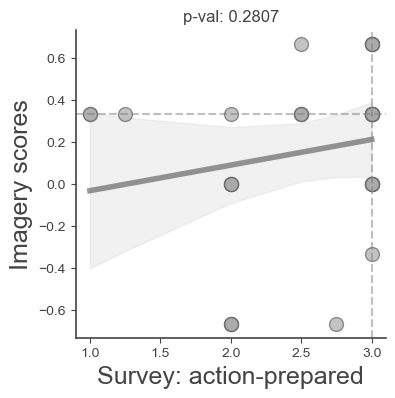

In [135]:
dispalay_regression_dicts(
    all_action_survey_scores,
    imagery_6_scores,
    'Survey: action-prepared', 
    'Imagery scores', 
    'reg_q1_vs_q6')

<Axes: title={'center': 'p-val: 0.7607'}, xlabel='Survey: action-prepared', ylabel='Imagery scores'>

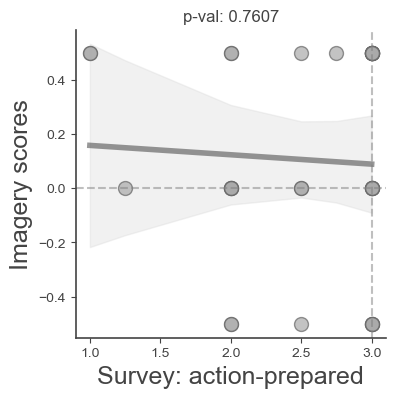

In [136]:
dispalay_regression_dicts(
    all_action_survey_scores,
    imagery_7_scores,
    'Survey: action-prepared', 
    'Imagery scores', 
    'reg_q1_vs_q7')

<Axes: title={'center': 'p-val: 0.6094'}, xlabel='Survey: action-prepared', ylabel='Imagery scores'>

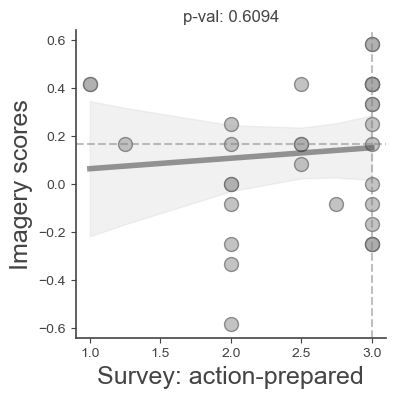

In [137]:
dispalay_regression_dicts(
    all_action_survey_scores,
    imagery_scores,
    'Survey: action-prepared', 
    'Imagery scores', 
    'reg_q1_vs_q6q7')

#### How about these question with gaze decoding accuracy?

<Axes: title={'center': 'p-val: 0.6342'}, xlabel='Imagery scores', ylabel='Gaze Accuracy'>

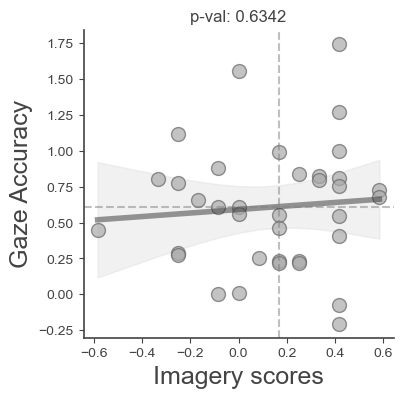

In [138]:
dispalay_regression_dicts(
    imagery_scores,
    acc_delay,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_delay')

<Axes: title={'center': 'p-val: 0.9004'}, xlabel='Imagery scores', ylabel='Gaze Accuracy'>

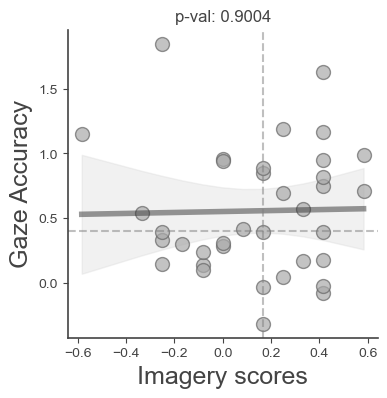

In [139]:
dispalay_regression_dicts(
    imagery_scores,
    acc_isi,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_isi')

<Axes: title={'center': 'p-val: 0.6059'}, xlabel='Imagery scores', ylabel='Gaze Accuracy'>

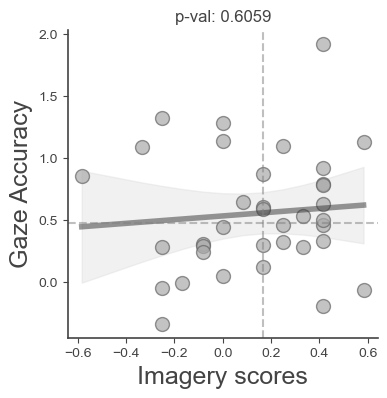

In [140]:
dispalay_regression_dicts(
    imagery_scores,
    acc_enc,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_enc')

<Axes: title={'center': 'p-val: 0.4765'}, xlabel='Imagery scores', ylabel='Gaze Accuracy'>

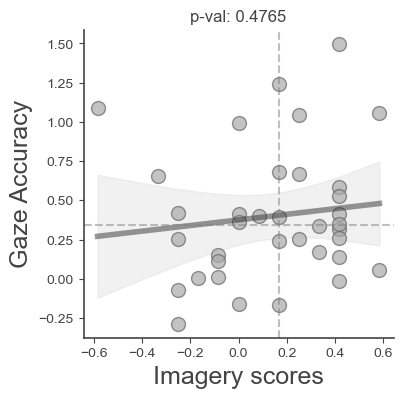

In [141]:
dispalay_regression_dicts(
    imagery_scores,
    acc_enc_isi,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_enc_isi')

<Axes: title={'center': 'p-val: 0.2885'}, xlabel='Imagery scores', ylabel='Gaze Accuracy'>

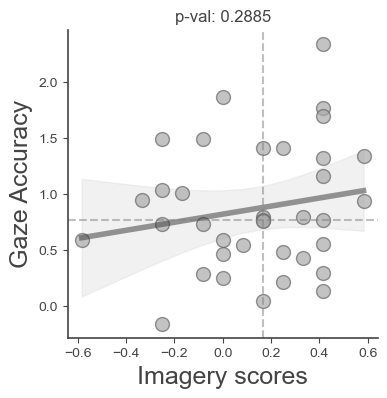

In [142]:
dispalay_regression_dicts(
    imagery_scores,
    acc_isi_delay,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_isi_delay')